# Reward Competition Elo Score Calculation

In [1]:
import re
import os
import sys
import string
from collections import defaultdict
import glob
import warnings
from datetime import datetime
from datetime import timedelta
import ast
from collections import Counter

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xlrd

In [3]:
# setting path
sys.path.append('../../../src')

In [4]:
from eloscore import eloscore

In [5]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

## TODO: ADD Summary

# Make it iterate through a list of sheets

- Notebook that calcuates the Elo Score of mice competing over access to a tone associated reward port
- The data is a spreadsheet of combination of subjects (as rows) against dates (as columns)

## Name of protocol for naming

- This name will be used to name files and title plots. Please change if you are using a different protocol or adding more details
    - **NOTE**: This should be changed based on the name the protocol

In [6]:
protocol_name = "reward_competition"

In [7]:
cohort_name = "pilot_3"

## Getting the file name of the raw data

- Default input folder and keyword to search the files for 
    - **NOTE**: This should not be changed unless there is a consistent change with the file naming convention

In [8]:
input_folder = "./data"

In [9]:
# Accomodates for both capitalization of the file names
raw_data_file_keyword = '*[rR]eward*'

# NOTE: If there is a set excel file used for this notebook, edit the cell below with the path to that in the "" (quotation marks)

In [10]:
raw_data_file_path = "./data/Reward_Comp_Scoring_Assignments (1).xlsx"

- Asking the user what the path to the recording files are, with the option of using wildcards

In [11]:
if not raw_data_file_path:
    raw_data_glob_pattern = input("""Type out the path(address) of the raw behavioral recording excel sheets.
    Remember that if you are using a relative path, it will be based off of the location of this Jupyter Notebook.

    Globbing can also be used if you want to search with a wild card(Capitalization matters). 
    i.e. './data/*Home*' will be able to find './data/Homecage_observations.xlsx'

    NOTE: If left blank, the path will automatically be guessed off of the default settings 
    """)

- By default, this will search for files that are in the `./data` folder (in the folder that this notebook is in) that have key word you specified in the file name

In [12]:
if not raw_data_file_path:

    # Using the user inputted path/pattern
    if raw_data_glob_pattern.strip():
        # Getting a list of all matching files
        raw_data_files_list = glob.glob(raw_data_glob_pattern.strip())
        # Checking if there were any files that matched
        if raw_data_files_list:
            raw_data_file_path = raw_data_files_list[0]
        else:
            raise ValueError("No files were found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))

    # Using the default pattern
    else:
        # Searching for matching files with recursion
        if glob.glob(os.path.join(input_folder + "**", raw_data_file_keyword)):
            raw_data_glob_pattern = os.path.join(input_folder + "**", raw_data_file_keyword)
            # Getting a list of all matching files
            raw_data_files_list = glob.glob(raw_data_glob_pattern)
        # Searching for matching files only in the specified folder
        elif glob.glob(os.path.join(input_folder, raw_data_file_keyword)):
            raw_data_glob_pattern = glob.glob(os.path.join(input_folder, raw_data_file_keyword))
            # Getting a list of all matching files
            raw_data_files_list = glob.glob(raw_data_glob_pattern)
        else:
            raise ValueError("No files were found in {} that had the keyword {} in it".format(input_folder, raw_data_file_keyword))


- Checking to see if only one file is specified

In [13]:
if not raw_data_file_path:

    if len(raw_data_files_list) >= 2:
        raise ValueError("More than one file was found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))
    else:
        # Using the first(and only file) as the file path
        raw_data_file_path = raw_data_files_list[0]

In [14]:
raw_data_file_path

'./data/Reward_Comp_Scoring_Assignments (1).xlsx'

## Getting a list of all the sheets

In [15]:
# Getting the sheet names for the excel file
xls = pd.ExcelFile(raw_data_file_path)
raw_data_sheet_names = xls.sheet_names

In [16]:
raw_data_sheet_names

['Master List',
 'Jocelyn',
 'Aidan',
 'Albert',
 'Erika',
 'Ezra',
 'Meghan',
 'Naeliz',
 'Leo']

# NOTE: If there is a set sheet names used for this notebook, edit the cell below with the name of the sheets each in quotation marks seperated by commas
   - i.e. `['CAGE 1', 'CAGE 2', 'CAGE 3', 'CAGE 4']`

In [17]:
inputted_sheet_names_list = ['Master List']

- Asking the user what sheets they want to use

In [18]:
if not inputted_sheet_names_list:

    inputted_sheet_names_string = input("""Type out the name of the sheets that you want to be processed. 
    Each name must be put in quotes and seperated by a comma(,). i.e. "CAGE3", "CAGE4"

    The available sheets are: {}

    Alternatively, you can use the index of the list of names above. 
    Remember, that Python is zero indexed so the first item will be have the 0 index, second the 1 index, and so on. 
    i.e. 1, 2

    NOTE: If left blank, all sheets will be used
    """.format(raw_data_sheet_names))

In [19]:
if not inputted_sheet_names_list:

    # Making a list out of the string of inputted sheet names
    if inputted_sheet_names_string:
        inputted_sheet_names_string = "[" + inputted_sheet_names_string + "]"
        # Turning the string into a list
        inputted_sheet_names_list = ast.literal_eval(inputted_sheet_names_string)
    # Using all the sheet names if no sheet name is specified
    else:
        inputted_sheet_names_list =  raw_data_sheet_names

In [20]:
inputted_sheet_names_list

['Master List']

- Converting all the numbers into the sheet name that the index of the number corresponds to

In [21]:
if not inputted_sheet_names_list:

    for index, sheet in enumerate(inputted_sheet_names_list):
        # Checking if the sheet name was a number
        if isinstance(sheet, int) and str(sheet).isdigit():
            inputted_sheet_names_list[index] =  raw_data_sheet_names[sheet]

In [22]:
inputted_sheet_names_list

['Master List']

- Checking to see if all the sheets are in the excel file

In [23]:
if not set(inputted_sheet_names_list).issubset(raw_data_sheet_names):
    # Getting all the sheets that were not in the original spreadsheet
    not_included_sheet_names = set(inputted_sheet_names_list) - set(raw_data_sheet_names)
    raise ValueError("All the listed sheet names are not in {}".format(not_included_sheet_names))

# NOTE: If there is a set row that has the column names, then enter the row number in the quotation marks

In [24]:
# Making the row number a string, so that "0" is treated as a True value
all_header_row = header_row = "0"
header_row = int(header_row)

## Finding the row for the header

- Headers are the row in a spreadsheet that has all the column names. Sometimes spreadsheets don't use the first row as the row with the column names. So, the row for the header will be asked or assumed to be the first row

In [25]:
sheet_name_to_everything = defaultdict(dict)
for sheet in inputted_sheet_names_list:
    if not all_header_row:
        print("\nCurrent Sheet Name: {}".format(sheet))    
        per_sheet_dataframe = pd.read_excel(raw_data_file_path, sheet_name=sheet, header=0)

        # Showing the columns that are chosen with the header being the 0th row
        print("Columns Names: {}".format(per_sheet_dataframe.columns))
        # Show the dataframe that would be created with the header being the 0th row
        print("First few rows of this dataframe:")
        print(pd.read_excel(raw_data_file_path, sheet_name=sheet, header=0).head())

        # Allowing the user the choose the row number for the header
        header_row = input("""Type the row number to be used as the header
        (AKA the row with the column name that you want to use.)
        If you want to keep the column names that were displayed, type 0.
        If you want to use a different row, then type the corresponding number. 

        The rows displayed in this cell are dataframes created from Pandas. 
        To use the row with the 0 index for column names, type 1. 
        For the row with the 1 index, it will be 2 and so on. i.e. 2

        If you are looking at the original spread sheet, remember that Python is zero indexed. 
        So the first row will be 0, second will be 1, and so on. 
        i.e. 1

        NOTE: If left blank, the original row that was used will be used.
        """).strip()

        if header_row == "":
            header_row = 0
        else:
            header_row = int(header_row)
    
    # Checking if any of the column names are from empty cells
    column_names = "".join([str(col) for col in pd.read_excel(raw_data_file_path, sheet_name=sheet, header=header_row).columns])
    # If a column name came from an empty cell, it would have "Unnamed" in it
    if "Unnamed" in column_names:
        raise ValueError("""Not all the cells in the chosen row are filled in.
                         Please choose a row that has the name of the columns
                         
                         The values in this row are: {}""".format(column_names))
    else:
        sheet_name_to_everything[sheet]["header_row"] = header_row

In [26]:
sheet_name_to_everything

defaultdict(dict, {'Master List': {'header_row': 0}})

## Reading in all the spreadsheets

In [27]:
# Going through each sheet and creating a dataframe of it
for key, value in sheet_name_to_everything.items():
    sheet_name_to_everything[key]["original_behavior_recording_dataframe"] = pd.read_excel(raw_data_file_path, sheet_name=key, header=value["header_row"])

In [28]:
sheet_name_to_everything[key]["original_behavior_recording_dataframe"].head()

,Date,Cage,Box,Match,Scorer,Trial 1 Winner,Trial 2 Winner,Trial 3 Winner,Trial 4 Winner,Trial 5 Winner,...,Trial 13 Winner,Trial 14 Winner,Trial 15 Winner,Trial 16 Winner,Trial 17 Winner,Trial 18 Winner,Trial 19 Winner,Mouse 1 Wins,Mouse 2 Wins,Ties
0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,1.1,1.2,1.2,1.1,tie,...,1.1,tie,1.2,1.2,1.2,1.2,1.2,6,9,4
1,2022-10-03,1,2,1.3 vs 1.4,Jocelyn,1.3,1.4,1.3,1.4,1.4,...,1.3,tie,1.4,1.3,1.3,1.4,tie,8,8,3
2,2022-10-03,2,3,2.1 vs 2.2,Jocelyn,2.2,2.1,2.1,2.1,2.1,...,2.2,2.2,2.1,2.2,2.1,2.1,2.2,13,5,1
3,2022-10-03,2,4,2.3 vs 2.4,Jocelyn,2.4,2.4,2.4,2.3,2.4,...,2.3,2.3,2.4,2.4,2.4,2.4,2.3,6,13,0
4,2022-10-03,3,1,3.1 vs 3.2,Meghan,3.2,3.1,3.1,3.2,3.2,...,3.1,3.1,3.1,3.1,3.1,3.1,3.1,14,5,0


In [29]:
sheet_name_to_everything[key]["original_behavior_recording_dataframe"].tail()

,Date,Cage,Box,Match,Scorer,Trial 1 Winner,Trial 2 Winner,Trial 3 Winner,Trial 4 Winner,Trial 5 Winner,...,Trial 13 Winner,Trial 14 Winner,Trial 15 Winner,Trial 16 Winner,Trial 17 Winner,Trial 18 Winner,Trial 19 Winner,Mouse 1 Wins,Mouse 2 Wins,Ties
67,2022-10-04,3,4,3.1vs3.2,Leo,3.2,3.2,3.2,3.1,3.1,...,3.2,tie,3.2,3.2,3.2,3.2,3.1,4,13,2
68,2022-10-04,2,1,2.3vs2.4,Aidan,2.4,2.3,2.3,2.3,2.3,...,2.3,2.4,2.3,2.3,2.3,2.3,tie,16,2,1
69,2022-10-04,2,2,2.1vs2.2,Albert,2.2,2.2,2.2,tie,2.2,...,tie,2.2,2.2,2.2,2.2,2.2,2.2,0,17,2
70,2022-10-04,1,3,1.3vs1.4,Aidan,1.3,1.3,1.4,1.4,1.4,...,tie,1.3,1.3,1.3,tie,tie,1.3,9,6,3
71,2022-10-04,1,4,1.1vs1.2,Albert,1.1,1.1,1.1,1.1,1.1,...,1.1,1.1,1.1,1.1,1.1,1.1,1.1,18,0,1


## Standarizing the Columns

- Making all the column names lower case and removing any extra spaces in the beginning and at the end

In [30]:
for key, value in sheet_name_to_everything.items():
    # Creating a dictionary that maps the original column name to the standarized one
    column_name_to_standarized = defaultdict(dict)
    for col in sheet_name_to_everything[key]["original_behavior_recording_dataframe"]:
        # Making the column name lower case and removing the spaces
        column_name_to_standarized[col] = str(col).lower().strip()
    sheet_name_to_everything[key]["column_name_to_standarized"] = column_name_to_standarized

In [31]:
sheet_name_to_everything[key]["column_name_to_standarized"]

defaultdict(dict,
            {'Date': 'date',
             'Cage': 'cage',
             'Box': 'box',
             'Match': 'match',
             'Scorer': 'scorer',
             'Trial 1 Winner': 'trial 1 winner',
             'Trial 2 Winner': 'trial 2 winner',
             'Trial 3 Winner': 'trial 3 winner',
             'Trial 4 Winner': 'trial 4 winner',
             'Trial 5 Winner': 'trial 5 winner',
             'Trial 6 Winner': 'trial 6 winner',
             'Trial 7 Winner': 'trial 7 winner',
             'Trial 8 Winner': 'trial 8 winner',
             'Trial 9 Winner': 'trial 9 winner',
             'Trial 10 Winner': 'trial 10 winner',
             'Trial 11 Winner': 'trial 11 winner',
             'Trial 12 Winner': 'trial 12 winner',
             'Trial 13 Winner': 'trial 13 winner',
             'Trial 14 Winner': 'trial 14 winner',
             'Trial 15 Winner': 'trial 15 winner',
             'Trial 16 Winner': 'trial 16 winner',
             'Trial 17 Winner': 'tr

In [32]:
# Renaming all the columns to the lower case and space removed version
for key, value in sheet_name_to_everything.items():
    sheet_name_to_everything[key]["processed_behavior_recording_dataframe"] = sheet_name_to_everything[key]["original_behavior_recording_dataframe"].rename(columns=sheet_name_to_everything[key]["column_name_to_standarized"])

In [33]:
sheet_name_to_everything[key]["processed_behavior_recording_dataframe"].head()

,date,cage,box,match,scorer,trial 1 winner,trial 2 winner,trial 3 winner,trial 4 winner,trial 5 winner,...,trial 13 winner,trial 14 winner,trial 15 winner,trial 16 winner,trial 17 winner,trial 18 winner,trial 19 winner,mouse 1 wins,mouse 2 wins,ties
0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,1.1,1.2,1.2,1.1,tie,...,1.1,tie,1.2,1.2,1.2,1.2,1.2,6,9,4
1,2022-10-03,1,2,1.3 vs 1.4,Jocelyn,1.3,1.4,1.3,1.4,1.4,...,1.3,tie,1.4,1.3,1.3,1.4,tie,8,8,3
2,2022-10-03,2,3,2.1 vs 2.2,Jocelyn,2.2,2.1,2.1,2.1,2.1,...,2.2,2.2,2.1,2.2,2.1,2.1,2.2,13,5,1
3,2022-10-03,2,4,2.3 vs 2.4,Jocelyn,2.4,2.4,2.4,2.3,2.4,...,2.3,2.3,2.4,2.4,2.4,2.4,2.3,6,13,0
4,2022-10-03,3,1,3.1 vs 3.2,Meghan,3.2,3.1,3.1,3.2,3.2,...,3.1,3.1,3.1,3.1,3.1,3.1,3.1,14,5,0


## Removing Unnecessary Columns

# TODO: Pick which columns to drop or keep

In [34]:
reward_competition_df = sheet_name_to_everything[key]["processed_behavior_recording_dataframe"]

In [35]:
reward_competition_df.columns

Index(['date', 'cage', 'box', 'match', 'scorer', 'trial 1 winner',
       'trial 2 winner', 'trial 3 winner', 'trial 4 winner', 'trial 5 winner',
       'trial 6 winner', 'trial 7 winner', 'trial 8 winner', 'trial 9 winner',
       'trial 10 winner', 'trial 11 winner', 'trial 12 winner',
       'trial 13 winner', 'trial 14 winner', 'trial 15 winner',
       'trial 16 winner', 'trial 17 winner', 'trial 18 winner',
       'trial 19 winner', 'mouse 1 wins', 'mouse 2 wins', 'ties'],
      dtype='object')

In [36]:
reward_competition_df = reward_competition_df.drop(["mouse 1 wins", "mouse 2 wins", "ties", " "], axis=1, errors="ignore")

In [37]:
columns_to_keep = [col for col in reward_competition_df.columns if "time" not in col.lower().strip()]

In [38]:
columns_to_keep

['date',
 'cage',
 'box',
 'match',
 'scorer',
 'trial 1 winner',
 'trial 2 winner',
 'trial 3 winner',
 'trial 4 winner',
 'trial 5 winner',
 'trial 6 winner',
 'trial 7 winner',
 'trial 8 winner',
 'trial 9 winner',
 'trial 10 winner',
 'trial 11 winner',
 'trial 12 winner',
 'trial 13 winner',
 'trial 14 winner',
 'trial 15 winner',
 'trial 16 winner',
 'trial 17 winner',
 'trial 18 winner',
 'trial 19 winner']

In [39]:
reward_competition_df = reward_competition_df[columns_to_keep].copy()

In [40]:
reward_competition_df.head()

,date,cage,box,match,scorer,trial 1 winner,trial 2 winner,trial 3 winner,trial 4 winner,trial 5 winner,...,trial 10 winner,trial 11 winner,trial 12 winner,trial 13 winner,trial 14 winner,trial 15 winner,trial 16 winner,trial 17 winner,trial 18 winner,trial 19 winner
0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,1.1,1.2,1.2,1.1,tie,...,1.2,tie,1.2,1.1,tie,1.2,1.2,1.2,1.2,1.2
1,2022-10-03,1,2,1.3 vs 1.4,Jocelyn,1.3,1.4,1.3,1.4,1.4,...,1.3,1.4,1.4,1.3,tie,1.4,1.3,1.3,1.4,tie
2,2022-10-03,2,3,2.1 vs 2.2,Jocelyn,2.2,2.1,2.1,2.1,2.1,...,2.1,2.1,2.1,2.2,2.2,2.1,2.2,2.1,2.1,2.2
3,2022-10-03,2,4,2.3 vs 2.4,Jocelyn,2.4,2.4,2.4,2.3,2.4,...,2.4,2.4,2.4,2.3,2.3,2.4,2.4,2.4,2.4,2.3
4,2022-10-03,3,1,3.1 vs 3.2,Meghan,3.2,3.1,3.1,3.2,3.2,...,3.1,3.1,3.1,3.1,3.1,3.1,3.1,3.1,3.1,3.1


In [41]:
reward_competition_df = reward_competition_df.dropna(subset=["trial 1 winner"])

## Add both IDs as a column

# TODO: Pick the match column

In [42]:
reward_competition_df["animal_ids"] = reward_competition_df["match"].apply(lambda x: tuple(sorted([all_ids.strip() for all_ids in re.findall(r"[-+]?(?:\d*\.\d+|\d+)", x)])))

In [43]:
reward_competition_df.head()

,date,cage,box,match,scorer,trial 1 winner,trial 2 winner,trial 3 winner,trial 4 winner,trial 5 winner,...,trial 11 winner,trial 12 winner,trial 13 winner,trial 14 winner,trial 15 winner,trial 16 winner,trial 17 winner,trial 18 winner,trial 19 winner,animal_ids
0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,1.1,1.2,1.2,1.1,tie,...,tie,1.2,1.1,tie,1.2,1.2,1.2,1.2,1.2,"(1.1, 1.2)"
1,2022-10-03,1,2,1.3 vs 1.4,Jocelyn,1.3,1.4,1.3,1.4,1.4,...,1.4,1.4,1.3,tie,1.4,1.3,1.3,1.4,tie,"(1.3, 1.4)"
2,2022-10-03,2,3,2.1 vs 2.2,Jocelyn,2.2,2.1,2.1,2.1,2.1,...,2.1,2.1,2.2,2.2,2.1,2.2,2.1,2.1,2.2,"(2.1, 2.2)"
3,2022-10-03,2,4,2.3 vs 2.4,Jocelyn,2.4,2.4,2.4,2.3,2.4,...,2.4,2.4,2.3,2.3,2.4,2.4,2.4,2.4,2.3,"(2.3, 2.4)"
4,2022-10-03,3,1,3.1 vs 3.2,Meghan,3.2,3.1,3.1,3.2,3.2,...,3.1,3.1,3.1,3.1,3.1,3.1,3.1,3.1,3.1,"(3.1, 3.2)"


In [44]:
reward_competition_df["cohort"] = cohort_name

In [45]:
cage_to_strain = {"1": "C57", "2": "C57", "3": "C57", "4": "CD1", "5": "CD1", "6": "CD1"}

# NOTE: If there are strains that are associated to each cage, then create a dictionary of cage numbers to strains inside the `{}`
- i.e. `cage_to_strain = {"1": "C57", "2": "C57", "3": "C57", "4": "CD1", "5": "CD1", "6": "CD1"}`

In [46]:
reward_competition_df["strain"] = reward_competition_df["cage"].astype(str).map(cage_to_strain)

In [47]:
all_cages = "_".join([str(cage) for cage in sorted(reward_competition_df["cage"].unique())])

In [48]:
all_cages

'1_2_3_4_5_6'

In [49]:
earliest_date = reward_competition_df["date"].min()
latest_date = reward_competition_df["date"].max()

In [50]:
earliest_date = str(earliest_date.date()).replace("-", "")

In [51]:
latest_date = str(latest_date.date()).replace("-", "")

In [52]:
earliest_date

'20221003'

In [53]:
latest_date

'20221004'

In [54]:
file_name = "{}_{}_trial_as_columns_cages_{}_date_{}_{}.csv".format(cohort_name, protocol_name, all_cages, earliest_date, latest_date)

reward_competition_df.to_csv(os.path.join("./proc/elo_score_spread_sheets/reward_competition_elo_score/", file_name))

## Melt 

In [55]:
reward_competition_df["index"] = reward_competition_df.index
reward_competition_df = reward_competition_df.reset_index(drop=True)

In [56]:
reward_competition_df.head()

,date,cage,box,match,scorer,trial 1 winner,trial 2 winner,trial 3 winner,trial 4 winner,trial 5 winner,...,trial 14 winner,trial 15 winner,trial 16 winner,trial 17 winner,trial 18 winner,trial 19 winner,animal_ids,cohort,strain,index
0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,1.1,1.2,1.2,1.1,tie,...,tie,1.2,1.2,1.2,1.2,1.2,"(1.1, 1.2)",pilot_3,C57,0
1,2022-10-03,1,2,1.3 vs 1.4,Jocelyn,1.3,1.4,1.3,1.4,1.4,...,tie,1.4,1.3,1.3,1.4,tie,"(1.3, 1.4)",pilot_3,C57,1
2,2022-10-03,2,3,2.1 vs 2.2,Jocelyn,2.2,2.1,2.1,2.1,2.1,...,2.2,2.1,2.2,2.1,2.1,2.2,"(2.1, 2.2)",pilot_3,C57,2
3,2022-10-03,2,4,2.3 vs 2.4,Jocelyn,2.4,2.4,2.4,2.3,2.4,...,2.3,2.4,2.4,2.4,2.4,2.3,"(2.3, 2.4)",pilot_3,C57,3
4,2022-10-03,3,1,3.1 vs 3.2,Meghan,3.2,3.1,3.1,3.2,3.2,...,3.1,3.1,3.1,3.1,3.1,3.1,"(3.1, 3.2)",pilot_3,C57,4


# TODO: Pick the columns to keep

In [57]:
melted_reward_competition_df = reward_competition_df.melt(id_vars=["index", "date", "cage", "box", "match", "scorer", "animal_ids"], 
        var_name="trial", 
        value_name="winner")

In [58]:
melted_reward_competition_df.head()

,index,date,cage,box,match,scorer,animal_ids,trial,winner
0,0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 1 winner,1.1
1,1,2022-10-03,1,2,1.3 vs 1.4,Jocelyn,"(1.3, 1.4)",trial 1 winner,1.3
2,2,2022-10-03,2,3,2.1 vs 2.2,Jocelyn,"(2.1, 2.2)",trial 1 winner,2.2
3,3,2022-10-03,2,4,2.3 vs 2.4,Jocelyn,"(2.3, 2.4)",trial 1 winner,2.4
4,4,2022-10-03,3,1,3.1 vs 3.2,Meghan,"(3.1, 3.2)",trial 1 winner,3.2


- Dropping all rows that don't contain Winner

In [59]:
melted_reward_competition_df = melted_reward_competition_df.dropna(subset="winner")

- Making all the ids into string

In [60]:
melted_reward_competition_df["winner"] = melted_reward_competition_df["winner"].astype(str)
melted_reward_competition_df["winner"] = melted_reward_competition_df["winner"].apply(lambda x: x.lower().strip())

In [61]:
melted_reward_competition_df["match"].unique()

array(['1.1 vs 1.2', '1.3 vs 1.4', '2.1 vs 2.2', '2.3 vs 2.4',
       '3.1 vs 3.2', '3.3 vs 3.4', '4.1 vs 4.2', '4.3 vs 4.4',
       '5.1 vs 5.2', '5.3 vs 5.4', '6.1 vs 6.2', '6.3 vs 6.4',
       '2.2 vs 2.4', '2.1 vs 2.3', '1.2 vs 1.4', '1.1 vs 1.3',
       '4.2 vs 4.4', '4.1 vs 4.3', '3.2 vs 3.4', '3.1 vs 3.3',
       '6.2 vs 6.4', '6.1 vs 6.3', '5.2 vs 5.4', '5.1 vs 5.3',
       '1.2 vs 1.3', '1.1 vs 1.4', '2.2 vs 2.3', '2.1 vs 2.4',
       '3.2 vs 3.3', '3.1 vs 3.4', '4.2 vs 4.3', '4.1 vs 4.4',
       '5.2 vs 5.3', '5.1 vs 5.4', '6.2 vs 6.3', '6.1 vs 6.4', '5.1vs5.4',
       '5.2vs5.3', '4.1vs4.4', '4.2vs4.3', '3.1vs3.4', '3.2vs3.3',
       '2.1vs2.4', '2.2vs2.3', '1.1vs1.4', '1.2vs1.3', '5.1vs5.3',
       '5.2vs5.4', '6.1vs6.3', '6.2vs6.4', '3.1vs3.3', '3.2vs3.4',
       '4.1vs4.3', '4.2vs4.4', '1.1vs1.3', '1.2vs1.4', '2.1vs2.3',
       '2.2v2.4', '6.3vs6.4', '6.1vs6.2', '5.3vs5.4', '5.1vs5.2',
       '4.3vs4.4', '4.1vs4.2', '3.3vs3.4', '3.1vs3.2', '2.3vs2.4',
       '2.1vs2.2', '

- Making a different column for ties

In [62]:
melted_reward_competition_df["tie"] = melted_reward_competition_df["winner"].apply(lambda x: True if "tie" in x.lower().strip() else False)

- Replacing tie with the first animal id for elo score plotting

In [63]:
melted_reward_competition_df["winner"] = melted_reward_competition_df.apply(lambda x: x["animal_ids"][0] if x["tie"] else x["winner"], axis=1)

In [64]:
melted_reward_competition_df[melted_reward_competition_df["tie"]]

,index,date,cage,box,match,scorer,animal_ids,trial,winner,tie
62,62,2022-10-04,5,3,5.3vs5.4,Aidan,"(5.3, 5.4)",trial 1 winner,5.3,True
90,18,2022-10-03,3,3,3.2 vs 3.4,Naeliz,"(3.2, 3.4)",trial 2 winner,3.2,True
99,27,2022-10-03,2,4,2.1 vs 2.4,Leo,"(2.1, 2.4)",trial 2 winner,2.1,True
105,33,2022-10-03,5,2,5.1 vs 5.4,Leo,"(5.1, 5.4)",trial 2 winner,5.1,True
120,48,2022-10-04,5,1,5.1vs5.3,Leo,"(5.1, 5.3)",trial 2 winner,5.1,True
...,...,...,...,...,...,...,...,...,...,...
1297,1,2022-10-03,1,2,1.3 vs 1.4,Jocelyn,"(1.3, 1.4)",trial 19 winner,1.3,True
1311,15,2022-10-03,1,4,1.1 vs 1.3,Meghan,"(1.1, 1.3)",trial 19 winner,1.1,True
1349,53,2022-10-04,3,2,3.2vs3.4,Aidan,"(3.2, 3.4)",trial 19 winner,3.2,True
1354,58,2022-10-04,2,3,2.1vs2.3,Leo,"(2.1, 2.3)",trial 19 winner,2.1,True


- Dropping all non tie and competition rows

In [65]:
melted_reward_competition_df["winner_is_number"] = melted_reward_competition_df["winner"].apply(lambda x: True if re.match(r'^-?\d+(?:\.\d+)$', x) else False)


In [66]:
melted_reward_competition_df = melted_reward_competition_df[melted_reward_competition_df["winner_is_number"] == True]
melted_reward_competition_df = melted_reward_competition_df.drop(columns=["winner_is_number"])

In [67]:
melted_reward_competition_df.head()

,index,date,cage,box,match,scorer,animal_ids,trial,winner,tie
0,0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 1 winner,1.1,False
1,1,2022-10-03,1,2,1.3 vs 1.4,Jocelyn,"(1.3, 1.4)",trial 1 winner,1.3,False
2,2,2022-10-03,2,3,2.1 vs 2.2,Jocelyn,"(2.1, 2.2)",trial 1 winner,2.2,False
3,3,2022-10-03,2,4,2.3 vs 2.4,Jocelyn,"(2.3, 2.4)",trial 1 winner,2.4,False
4,4,2022-10-03,3,1,3.1 vs 3.2,Meghan,"(3.1, 3.2)",trial 1 winner,3.2,False


- Getting the number of the trial so that we can order by number(instead of string, which would make 11 come before 2)

In [68]:
melted_reward_competition_df["trial_number"] = melted_reward_competition_df["trial"].apply(lambda x: int(x.lower().strip("trial").strip("winner")))

In [69]:
melted_reward_competition_df = melted_reward_competition_df.sort_values(["index", "trial_number"])

In [70]:
melted_reward_competition_df.head()

,index,date,cage,box,match,scorer,animal_ids,trial,winner,tie,trial_number
0,0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 1 winner,1.1,False,1
72,0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 2 winner,1.2,False,2
144,0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 3 winner,1.2,False,3
216,0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 4 winner,1.1,False,4
288,0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 5 winner,1.1,True,5


In [71]:
melted_reward_competition_df["trial_number"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

## Add a column for the loser ID

In [72]:
melted_reward_competition_df.columns

Index(['index', 'date', 'cage', 'box', 'match', 'scorer', 'animal_ids',
       'trial', 'winner', 'tie', 'trial_number'],
      dtype='object')

In [73]:
melted_reward_competition_df.head()

,index,date,cage,box,match,scorer,animal_ids,trial,winner,tie,trial_number
0,0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 1 winner,1.1,False,1
72,0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 2 winner,1.2,False,2
144,0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 3 winner,1.2,False,3
216,0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 4 winner,1.1,False,4
288,0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 5 winner,1.1,True,5


In [74]:
melted_reward_competition_df["loser"] = melted_reward_competition_df.apply(lambda x: (list(set(x["animal_ids"]) - set([x["winner"]]))[0]), axis=1)

In [75]:
melted_reward_competition_df["loser"].unique()

array(['1.2', '1.1', '1.4', '1.3', '2.1', '2.2', '2.3', '2.4', '3.1',
       '3.2', '3.4', '3.3', '4.2', '4.1', '4.3', '4.4', '5.1', '5.2',
       '5.3', '5.4', '6.1', '6.2', '6.4', '6.3'], dtype=object)

In [76]:
melted_reward_competition_df.head(n=5)

,index,date,cage,box,match,scorer,animal_ids,trial,winner,tie,trial_number,loser
0,0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 1 winner,1.1,False,1,1.2
72,0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 2 winner,1.2,False,2,1.1
144,0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 3 winner,1.2,False,3,1.1
216,0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 4 winner,1.1,False,4,1.2
288,0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 5 winner,1.1,True,5,1.2


In [77]:
melted_reward_competition_df.tail(n=5)

,index,date,cage,box,match,scorer,animal_ids,trial,winner,tie,trial_number,loser
1079,71,2022-10-04,1,4,1.1vs1.2,Albert,"(1.1, 1.2)",trial 15 winner,1.1,False,15,1.2
1151,71,2022-10-04,1,4,1.1vs1.2,Albert,"(1.1, 1.2)",trial 16 winner,1.1,False,16,1.2
1223,71,2022-10-04,1,4,1.1vs1.2,Albert,"(1.1, 1.2)",trial 17 winner,1.1,False,17,1.2
1295,71,2022-10-04,1,4,1.1vs1.2,Albert,"(1.1, 1.2)",trial 18 winner,1.1,False,18,1.2
1367,71,2022-10-04,1,4,1.1vs1.2,Albert,"(1.1, 1.2)",trial 19 winner,1.1,False,19,1.2


## Calculating ELO Score

- Example calculation

In [78]:
eloscore.calculate_elo_score(subject_elo_score=1000, agent_elo_score=2000)

1019.9

# TODO: Find a way to account for ties

## Get the Elo score for all the events

In [79]:
eloscore.update_elo_score(winner_id="A", loser_id="B")

defaultdict(<function eloscore.eloscore.update_elo_score.<locals>.<lambda>()>,
            {'A': 1010.0, 'B': 990.0})

- Function that creates a dictionary that has the original/updated elo score for each event

In [80]:
cage_to_elo_score_dict = defaultdict(dict)
for cage in melted_reward_competition_df["cage"].unique():
    cage_df = melted_reward_competition_df[melted_reward_competition_df["cage"] == cage]
    cage_to_elo_score_dict[cage] = eloscore.iterate_elo_score_calculation_for_dataframe(dataframe=cage_df, winner_column="winner", loser_column="loser", additional_columns=["index", "date", "cage", "box", "match", "scorer", "animal_ids", "trial", "trial_number"])

In [81]:
cage_to_elo_score_dict.keys()

dict_keys([1, 2, 3, 4, 5, 6])

In [82]:
cage_to_elo_score_dict[list(cage_to_elo_score_dict.keys())[0]][0]

{'total_match_number': 1,
 'subject_id': '1.1',
 'agent_id': '1.2',
 'original_elo_score': 1000,
 'updated_elo_score': 1010.0,
 'win_draw_loss': 1,
 'subject_ranking': 1,
 'agent_ranking': 2,
 'index': 0,
 'date': Timestamp('2022-10-03 00:00:00'),
 'cage': 1,
 'box': 1,
 'match': '1.1 vs 1.2',
 'scorer': 'Jocelyn',
 'animal_ids': ('1.1', '1.2'),
 'trial': 'trial 1 winner',
 'trial_number': 1}

- Turning the dictionary into a dataframe

In [83]:
all_cage_elo_score_list = []
for key in cage_to_elo_score_dict.keys():
    cage_elo_score_df = pd.DataFrame.from_dict(cage_to_elo_score_dict[key], orient="index")
    cage_elo_score_df.insert(0, 'total_trial_number', range(0, 0 + len(cage_elo_score_df)))
    print(cage_elo_score_df)
    all_cage_elo_score_list.append(cage_elo_score_df)


     total_trial_number  total_match_number subject_id agent_id  \
0                     0                   1        1.1      1.2   
1                     1                   1        1.2      1.1   
2                     2                   2        1.2      1.1   
3                     3                   2        1.1      1.2   
4                     4                   3        1.2      1.1   
..                  ...                 ...        ...      ...   
451                 451                 226        1.2      1.1   
452                 452                 227        1.1      1.2   
453                 453                 227        1.2      1.1   
454                 454                 228        1.1      1.2   
455                 455                 228        1.2      1.1   

     original_elo_score  updated_elo_score  win_draw_loss  subject_ranking  \
0                1000.0             1010.0              1                1   
1                1000.0              99

In [84]:
all_cage_elo_score_df = pd.concat(all_cage_elo_score_list)

In [85]:
all_cage_elo_score_df.head()

,total_trial_number,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,subject_ranking,agent_ranking,index,date,cage,box,match,scorer,animal_ids,trial,trial_number
0,0,1,1.1,1.2,1000.0,1010.0,1,1,2,0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 1 winner,1
1,1,1,1.2,1.1,1000.0,990.0,0,2,1,0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 1 winner,1
2,2,2,1.2,1.1,990.0,1000.6,1,1,2,0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 2 winner,2
3,3,2,1.1,1.2,1010.0,999.4,0,2,1,0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 2 winner,2
4,4,3,1.2,1.1,1000.6,1010.6,1,1,2,0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 3 winner,3


In [86]:
all_cage_elo_score_df.tail()

,total_trial_number,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,subject_ranking,agent_ranking,index,date,cage,box,match,scorer,animal_ids,trial,trial_number
451,451,226,6.2,6.1,743.4,739.7,0,4,3,61,2022-10-04,6,2,6.1vs6.2,Naeliz,"(6.1, 6.2)",trial 17 winner,17
452,452,227,6.1,6.2,1003.9,1007.5,1,3,4,61,2022-10-04,6,2,6.1vs6.2,Naeliz,"(6.1, 6.2)",trial 18 winner,18
453,453,227,6.2,6.1,739.7,736.1,0,4,3,61,2022-10-04,6,2,6.1vs6.2,Naeliz,"(6.1, 6.2)",trial 18 winner,18
454,454,228,6.2,6.1,736.1,752.6,1,4,3,61,2022-10-04,6,2,6.1vs6.2,Naeliz,"(6.1, 6.2)",trial 19 winner,19
455,455,228,6.1,6.2,1007.5,991.0,0,3,4,61,2022-10-04,6,2,6.1vs6.2,Naeliz,"(6.1, 6.2)",trial 19 winner,19


In [87]:
if cage_to_strain:
    all_cage_elo_score_df["strain"] = all_cage_elo_score_df["cage"].astype(str).map(cage_to_strain)

- Adding the cohort

In [88]:
all_cage_elo_score_df["experiment_type"] = protocol_name
all_cage_elo_score_df["cohort"] = cohort_name

In [89]:
all_cage_elo_score_df.head()

,total_trial_number,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,subject_ranking,agent_ranking,index,...,cage,box,match,scorer,animal_ids,trial,trial_number,strain,experiment_type,cohort
0,0,1,1.1,1.2,1000.0,1010.0,1,1,2,0,...,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 1 winner,1,C57,reward_competition,pilot_3
1,1,1,1.2,1.1,1000.0,990.0,0,2,1,0,...,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 1 winner,1,C57,reward_competition,pilot_3
2,2,2,1.2,1.1,990.0,1000.6,1,1,2,0,...,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 2 winner,2,C57,reward_competition,pilot_3
3,3,2,1.1,1.2,1010.0,999.4,0,2,1,0,...,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 2 winner,2,C57,reward_competition,pilot_3
4,4,3,1.2,1.1,1000.6,1010.6,1,1,2,0,...,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 3 winner,3,C57,reward_competition,pilot_3


In [90]:
all_cage_elo_score_df.head()

,total_trial_number,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,subject_ranking,agent_ranking,index,...,cage,box,match,scorer,animal_ids,trial,trial_number,strain,experiment_type,cohort
0,0,1,1.1,1.2,1000.0,1010.0,1,1,2,0,...,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 1 winner,1,C57,reward_competition,pilot_3
1,1,1,1.2,1.1,1000.0,990.0,0,2,1,0,...,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 1 winner,1,C57,reward_competition,pilot_3
2,2,2,1.2,1.1,990.0,1000.6,1,1,2,0,...,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 2 winner,2,C57,reward_competition,pilot_3
3,3,2,1.1,1.2,1010.0,999.4,0,2,1,0,...,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 2 winner,2,C57,reward_competition,pilot_3
4,4,3,1.2,1.1,1000.6,1010.6,1,1,2,0,...,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 3 winner,3,C57,reward_competition,pilot_3


## Saving the Elo Score Dataframes

- Create folders to save processed data

- Adding the cage information for each cage

In [91]:
all_cage_elo_score_df.head()

,total_trial_number,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,subject_ranking,agent_ranking,index,...,cage,box,match,scorer,animal_ids,trial,trial_number,strain,experiment_type,cohort
0,0,1,1.1,1.2,1000.0,1010.0,1,1,2,0,...,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 1 winner,1,C57,reward_competition,pilot_3
1,1,1,1.2,1.1,1000.0,990.0,0,2,1,0,...,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 1 winner,1,C57,reward_competition,pilot_3
2,2,2,1.2,1.1,990.0,1000.6,1,1,2,0,...,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 2 winner,2,C57,reward_competition,pilot_3
3,3,2,1.1,1.2,1010.0,999.4,0,2,1,0,...,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 2 winner,2,C57,reward_competition,pilot_3
4,4,3,1.2,1.1,1000.6,1010.6,1,1,2,0,...,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 3 winner,3,C57,reward_competition,pilot_3


In [92]:
id_to_final_elo_score_dict = defaultdict(dict)
for index, subject_id in enumerate(sorted(all_cage_elo_score_df["subject_id"].unique())):
    per_subject_df = all_cage_elo_score_df[all_cage_elo_score_df["subject_id"] == subject_id]
    id_to_final_elo_score_dict[index]["subject_id"] = subject_id

    id_to_final_elo_score_dict[index]["final_elo_score"] = per_subject_df.iloc[-1]["updated_elo_score"]
    id_to_final_elo_score_dict[index]["cohort"] = per_subject_df.iloc[-1]["cohort"]
    id_to_final_elo_score_dict[index]["strain"] = per_subject_df.iloc[-1]["strain"]
    id_to_final_elo_score_dict[index]["cage"] = per_subject_df.iloc[-1]["cage"]

    

In [93]:
id_to_final_elo_score_dict

defaultdict(dict,
            {0: {'subject_id': '1.1',
              'final_elo_score': 1196.9,
              'cohort': 'pilot_3',
              'strain': 'C57',
              'cage': 1},
             1: {'subject_id': '1.2',
              'final_elo_score': 974.3,
              'cohort': 'pilot_3',
              'strain': 'C57',
              'cage': 1},
             2: {'subject_id': '1.3',
              'final_elo_score': 1011.1,
              'cohort': 'pilot_3',
              'strain': 'C57',
              'cage': 1},
             3: {'subject_id': '1.4',
              'final_elo_score': 817.7,
              'cohort': 'pilot_3',
              'strain': 'C57',
              'cage': 1},
             4: {'subject_id': '2.1',
              'final_elo_score': 1010.3,
              'cohort': 'pilot_3',
              'strain': 'C57',
              'cage': 2},
             5: {'subject_id': '2.2',
              'final_elo_score': 1121.9,
              'cohort': 'pilot_3',
              '

In [94]:
id_to_final_elo_score_df = pd.DataFrame.from_dict(id_to_final_elo_score_dict, orient="index")
# Adding protocol name
id_to_final_elo_score_df["experiment_type"] = protocol_name
# Adding rank
id_to_final_elo_score_df["rank"] = id_to_final_elo_score_df.groupby("cage")["final_elo_score"].rank("dense", ascending=False)
# Sorting by cage and then id
id_to_final_elo_score_df = id_to_final_elo_score_df.sort_values(by=['cage', "subject_id"], ascending=True).reset_index(drop=True)

In [95]:
id_to_final_elo_score_df["rank"] = id_to_final_elo_score_df.groupby("cage")["final_elo_score"].rank("dense", ascending=False)

In [96]:
id_to_final_elo_score_df = id_to_final_elo_score_df.sort_values(by=['cage', "subject_id"], ascending=True).reset_index(drop=True)

In [97]:
id_to_final_elo_score_df.head()

,subject_id,final_elo_score,cohort,strain,cage,experiment_type,rank
0,1.1,1196.9,pilot_3,C57,1,reward_competition,1.0
1,1.2,974.3,pilot_3,C57,1,reward_competition,3.0
2,1.3,1011.1,pilot_3,C57,1,reward_competition,2.0
3,1.4,817.7,pilot_3,C57,1,reward_competition,4.0
4,2.1,1010.3,pilot_3,C57,2,reward_competition,3.0


In [98]:
id_to_final_elo_score_df.tail()

,subject_id,final_elo_score,cohort,strain,cage,experiment_type,rank
19,5.4,954.6,pilot_3,CD1,5,reward_competition,3.0
20,6.1,991.0,pilot_3,CD1,6,reward_competition,3.0
21,6.2,752.6,pilot_3,CD1,6,reward_competition,4.0
22,6.3,1235.4,pilot_3,CD1,6,reward_competition,1.0
23,6.4,1021.0,pilot_3,CD1,6,reward_competition,2.0


# Plotting the Elo Score by match number

In [99]:
plot_output_directory = "./proc/plots/reward_competition/cage_{}_date_{}_{}".format(all_cages, earliest_date, latest_date)

In [100]:
plot_output_directory

'./proc/plots/reward_competition/cage_1_2_3_4_5_6_date_20221003_20221004'

In [101]:
os.makedirs(plot_output_directory, exist_ok=True)

In [102]:
all_cage_elo_score_df["subject_id"] = all_cage_elo_score_df["subject_id"].astype(str)
all_cage_elo_score_df["agent_id"] = all_cage_elo_score_df["agent_id"].astype(str)

In [103]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

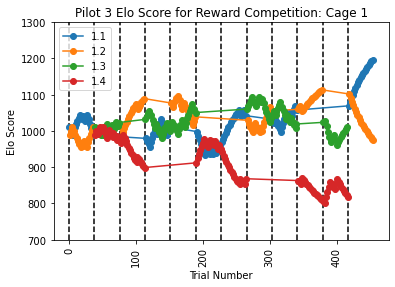

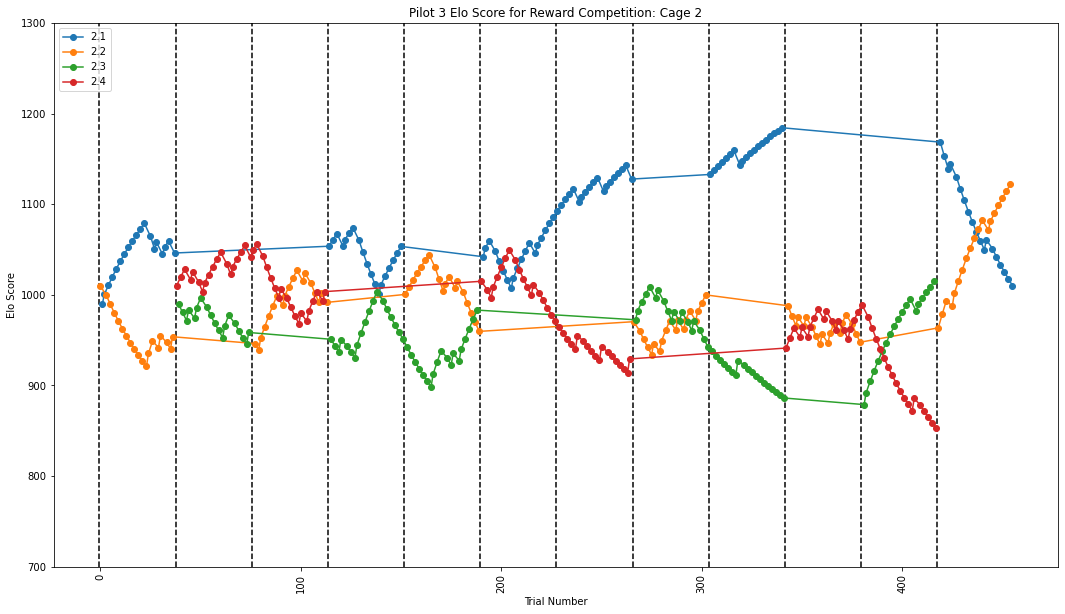

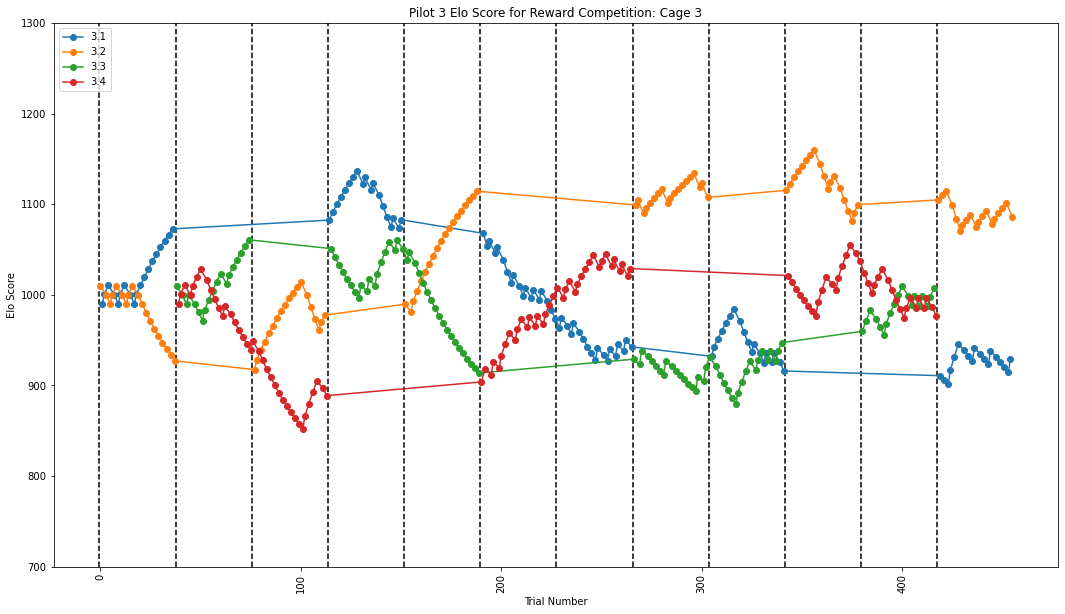

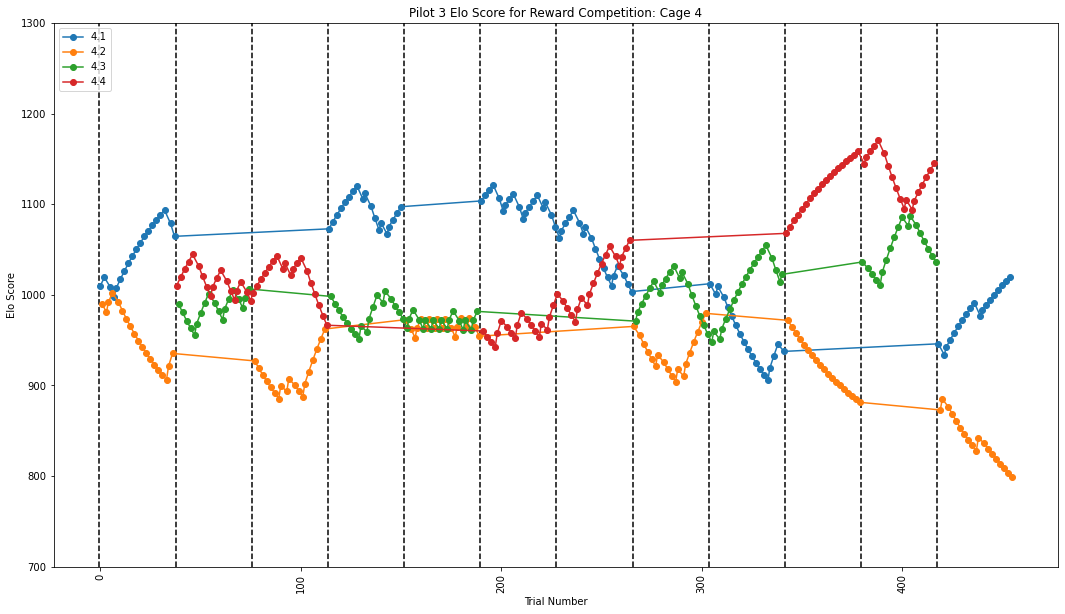

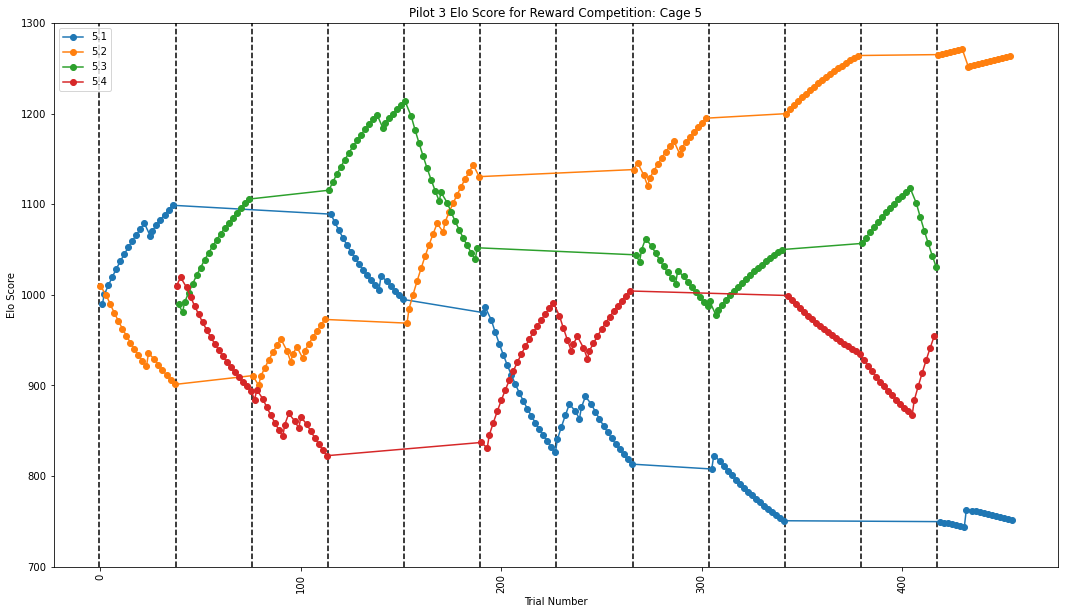

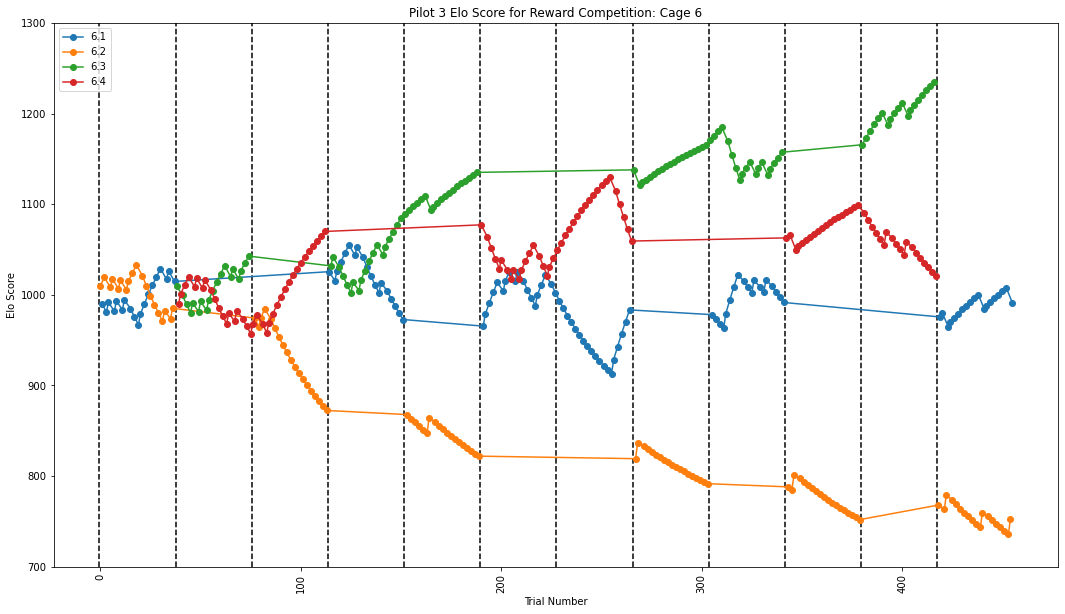

In [104]:
for cage in all_cage_elo_score_df["cage"].unique():
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = (18,10)
    per_cage_df = all_cage_elo_score_df[all_cage_elo_score_df["cage"] == cage]
       
    for index in per_cage_df["index"].unique():
        first_session_in_trial = per_cage_df[per_cage_df["index"] == index].iloc[0]["total_trial_number"]
        plt.vlines(x=[first_session_in_trial - 0.5], ymin=700, ymax=1300, colors='black', linestyle='dashed')

    
    
    # Drawing a line for each subject
    for subject in sorted(per_cage_df["subject_id"].unique()):
        # Getting all the rows with the current subject
        subject_df = per_cage_df[per_cage_df["subject_id"] == subject]
        # Making the dates into days after the first session by subtracting all the dates by the first date
        plt.plot(subject_df["total_trial_number"], subject_df["updated_elo_score"], '-o', label=subject)
    
    # Labeling the X/Y Axis and the title
    ax.set_xlabel("Trial Number")
    ax.set_ylabel("Elo Score")
    ax.set_title("{} Elo Score for {}: Cage {}".format(" ".join(cohort_name.split("_")).capitalize(), string.capwords(" ".join(protocol_name.split("_"))), cage))
    # To show the legend
    ax.legend(loc="upper left")
    plt.xticks(rotation=90)
    plt.ylim(700, 1300) 
    file_name = "{}_{}_elo_score_{}_date_{}_{}.png".format(cohort_name, protocol_name, cage, earliest_date, latest_date)
    plt.savefig(os.path.join(plot_output_directory, file_name))  
    
    plt.show()

# Saving the Dataframes

In [105]:
elo_score_spreadsheet_output_directory = "./proc/elo_score_spread_sheets/{}_elo_score/cage_{}_date_{}_{}".format(protocol_name, all_cages, earliest_date, latest_date)

In [106]:
elo_score_spreadsheet_output_directory

'./proc/elo_score_spread_sheets/reward_competition_elo_score/cage_1_2_3_4_5_6_date_20221003_20221004'

In [107]:
os.makedirs(elo_score_spreadsheet_output_directory, exist_ok=True)

In [108]:
file_name = "{}_elo_score_history_cages_{}_date_{}_{}.csv".format(protocol_name, all_cages, earliest_date, latest_date)
all_cage_elo_score_df.to_csv(os.path.join(elo_score_spreadsheet_output_directory, file_name))

In [109]:
file_name = "{}_final_elo_score_cages_{}_date_{}_{}.csv".format(protocol_name, all_cages, earliest_date, latest_date)
id_to_final_elo_score_df.to_csv(os.path.join(elo_score_spreadsheet_output_directory, file_name))

## Seeing which subject is the dominant or submissive

- Grouping all the rows with the same pair

In [110]:
all_processed_behavior_recording_df = melted_reward_competition_df

In [111]:
all_processed_behavior_recording_df.head()

,index,date,cage,box,match,scorer,animal_ids,trial,winner,tie,trial_number,loser
0,0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 1 winner,1.1,False,1,1.2
72,0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 2 winner,1.2,False,2,1.1
144,0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 3 winner,1.2,False,3,1.1
216,0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 4 winner,1.1,False,4,1.2
288,0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,"(1.1, 1.2)",trial 5 winner,1.1,True,5,1.2


In [112]:
all_processed_behavior_recording_df.columns

Index(['index', 'date', 'cage', 'box', 'match', 'scorer', 'animal_ids',
       'trial', 'winner', 'tie', 'trial_number', 'loser'],
      dtype='object')

In [113]:
['date', 'cage', 'match', 'animal_ids', 'trial', 'winner', 'tie', 'loser']

['date', 'cage', 'match', 'animal_ids', 'trial', 'winner', 'tie', 'loser']

- Removing columns that would be unnecessary for the pairings

In [114]:
all_processed_behavior_recording_df = all_processed_behavior_recording_df[['date', 'cage', 'match', 'animal_ids', 'trial', 'winner', 'tie', 'loser']]
all_processed_behavior_recording_df['processed_cage_number'] = all_processed_behavior_recording_df['cage'].astype(int)

/tmp/ipykernel_2189/634520334.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_processed_behavior_recording_df['processed_cage_number'] = all_processed_behavior_recording_df['cage'].astype(int)


In [115]:
all_processed_behavior_recording_df.head()

,date,cage,match,animal_ids,trial,winner,tie,loser,processed_cage_number
0,2022-10-03,1,1.1 vs 1.2,"(1.1, 1.2)",trial 1 winner,1.1,False,1.2,1
72,2022-10-03,1,1.1 vs 1.2,"(1.1, 1.2)",trial 2 winner,1.2,False,1.1,1
144,2022-10-03,1,1.1 vs 1.2,"(1.1, 1.2)",trial 3 winner,1.2,False,1.1,1
216,2022-10-03,1,1.1 vs 1.2,"(1.1, 1.2)",trial 4 winner,1.1,False,1.2,1
288,2022-10-03,1,1.1 vs 1.2,"(1.1, 1.2)",trial 5 winner,1.1,True,1.2,1


- Adding a tie to the list of winners and losers if it's a tie

In [116]:
all_processed_behavior_recording_df["winner"] = all_processed_behavior_recording_df.apply(lambda x: "tie" if x["tie"] else x["winner"], axis=1)
all_processed_behavior_recording_df["loser"] = all_processed_behavior_recording_df.apply(lambda x: "tie" if x["tie"] else x["loser"], axis=1)

/tmp/ipykernel_2189/3932701632.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_processed_behavior_recording_df["winner"] = all_processed_behavior_recording_df.apply(lambda x: "tie" if x["tie"] else x["winner"], axis=1)
/tmp/ipykernel_2189/3932701632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_processed_behavior_recording_df["loser"] = all_processed_behavior_recording_df.apply(lambda x: "tie" if x["tie"] else x["loser"], axis=1)


In [117]:
all_processed_behavior_recording_df[all_processed_behavior_recording_df["tie"]].head()

,date,cage,match,animal_ids,trial,winner,tie,loser,processed_cage_number
288,2022-10-03,1,1.1 vs 1.2,"(1.1, 1.2)",trial 5 winner,tie,True,tie,1
504,2022-10-03,1,1.1 vs 1.2,"(1.1, 1.2)",trial 8 winner,tie,True,tie,1
720,2022-10-03,1,1.1 vs 1.2,"(1.1, 1.2)",trial 11 winner,tie,True,tie,1
936,2022-10-03,1,1.1 vs 1.2,"(1.1, 1.2)",trial 14 winner,tie,True,tie,1
577,2022-10-03,1,1.3 vs 1.4,"(1.3, 1.4)",trial 9 winner,tie,True,tie,1


- Making a list of all the wins and loses

In [118]:
all_wins_per_pair = all_processed_behavior_recording_df.groupby(["animal_ids", "date"])['winner'].apply(list)
all_loses_per_pair = all_processed_behavior_recording_df.groupby(["animal_ids", "date"])['loser'].apply(list)

In [119]:
all_competition_per_pair_df = pd.concat([all_wins_per_pair, all_loses_per_pair], axis=1).reset_index()

In [120]:
all_competition_per_pair_df = all_competition_per_pair_df.rename(columns={k: "rc_" + k for k in all_competition_per_pair_df.columns})

In [121]:
all_competition_per_pair_df

,rc_animal_ids,rc_date,rc_winner,rc_loser
0,"(1.1, 1.2)",2022-10-03,"[1.1, 1.2, 1.2, 1.1, tie, 1.1, 1.1, tie, 1.1, ...","[1.2, 1.1, 1.1, 1.2, tie, 1.2, 1.2, tie, 1.2, ..."
1,"(1.1, 1.2)",2022-10-04,"[1.1, 1.1, 1.1, 1.1, 1.1, tie, 1.1, 1.1, 1.1, ...","[1.2, 1.2, 1.2, 1.2, 1.2, tie, 1.2, 1.2, 1.2, ..."
2,"(1.1, 1.3)",2022-10-03,"[1.3, 1.3, 1.3, 1.3, 1.1, 1.1, tie, 1.1, 1.3, ...","[1.1, 1.1, 1.1, 1.1, 1.3, 1.3, tie, 1.3, 1.1, ..."
3,"(1.1, 1.3)",2022-10-04,"[1.3, 1.3, tie, 1.3, 1.3, 1.3, 1.3, 1.1, tie, ...","[1.1, 1.1, tie, 1.1, 1.1, 1.1, 1.1, 1.3, tie, ..."
4,"(1.1, 1.4)",2022-10-03,"[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.1, ...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.4, 1.4, ..."
...,...,...,...,...
67,"(6.2, 6.3)",2022-10-04,"[6.3, 6.2, 6.3, 6.3, 6.3, 6.3, 6.3, 6.3, 6.3, ...","[6.2, 6.3, 6.2, 6.2, 6.2, 6.2, 6.2, 6.2, 6.2, ..."
68,"(6.2, 6.4)",2022-10-03,"[6.4, 6.4, 6.2, 6.2, 6.4, 6.4, 6.4, 6.4, 6.4, ...","[6.2, 6.2, 6.4, 6.4, 6.2, 6.2, 6.2, 6.2, 6.2, ..."
69,"(6.2, 6.4)",2022-10-04,"[6.4, 6.4, 6.2, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, ...","[6.2, 6.2, 6.4, 6.2, 6.2, 6.2, 6.2, 6.2, 6.2, ..."
70,"(6.3, 6.4)",2022-10-03,"[6.3, 6.4, 6.4, 6.4, 6.3, 6.4, 6.3, 6.4, 6.3, ...","[6.4, 6.3, 6.3, 6.3, 6.4, 6.3, 6.4, 6.3, 6.4, ..."


- Seeing how often the winners or losers change

In [122]:
# Dropping all the ties
all_competition_per_pair_df["rc_winner_no_ties"] = all_competition_per_pair_df.apply(lambda row: [x for x in row["rc_winner"] if x in row["rc_animal_ids"]], axis=1)
all_competition_per_pair_df["rc_loser_no_ties"] = all_competition_per_pair_df.apply(lambda row: [x for x in row["rc_loser"] if x in row["rc_animal_ids"]], axis=1)

In [123]:
# Comparing the each item with the item after it to see if they are the same of not
all_competition_per_pair_df["rc_different_result_as_previous"] = all_competition_per_pair_df["rc_winner_no_ties"].apply(lambda x: [True if left != right else False for (left, right) in zip(x[1:], x[:-1])])

In [124]:
all_competition_per_pair_df["rc_number_of_switches"] = all_competition_per_pair_df["rc_different_result_as_previous"].apply(lambda x: sum(x))

In [125]:
all_competition_per_pair_df

,rc_animal_ids,rc_date,rc_winner,rc_loser,rc_winner_no_ties,rc_loser_no_ties,rc_different_result_as_previous,rc_number_of_switches
0,"(1.1, 1.2)",2022-10-03,"[1.1, 1.2, 1.2, 1.1, tie, 1.1, 1.1, tie, 1.1, ...","[1.2, 1.1, 1.1, 1.2, tie, 1.2, 1.2, tie, 1.2, ...","[1.1, 1.2, 1.2, 1.1, 1.1, 1.1, 1.1, 1.2, 1.2, ...","[1.2, 1.1, 1.1, 1.2, 1.2, 1.2, 1.2, 1.1, 1.1, ...","[True, False, True, False, False, False, True,...",5
1,"(1.1, 1.2)",2022-10-04,"[1.1, 1.1, 1.1, 1.1, 1.1, tie, 1.1, 1.1, 1.1, ...","[1.2, 1.2, 1.2, 1.2, 1.2, tie, 1.2, 1.2, 1.2, ...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, ...","[False, False, False, False, False, False, Fal...",0
2,"(1.1, 1.3)",2022-10-03,"[1.3, 1.3, 1.3, 1.3, 1.1, 1.1, tie, 1.1, 1.3, ...","[1.1, 1.1, 1.1, 1.1, 1.3, 1.3, tie, 1.3, 1.1, ...","[1.3, 1.3, 1.3, 1.3, 1.1, 1.1, 1.1, 1.3, 1.1, ...","[1.1, 1.1, 1.1, 1.1, 1.3, 1.3, 1.3, 1.1, 1.3, ...","[False, False, False, True, False, False, True...",4
3,"(1.1, 1.3)",2022-10-04,"[1.3, 1.3, tie, 1.3, 1.3, 1.3, 1.3, 1.1, tie, ...","[1.1, 1.1, tie, 1.1, 1.1, 1.1, 1.1, 1.3, tie, ...","[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.1, 1.1, 1.3, ...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.3, 1.3, 1.1, ...","[False, False, False, False, False, True, Fals...",6
4,"(1.1, 1.4)",2022-10-03,"[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.1, ...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.4, 1.4, ...","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.1, ...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.4, 1.4, ...","[False, False, False, False, False, False, Tru...",7
...,...,...,...,...,...,...,...,...
67,"(6.2, 6.3)",2022-10-04,"[6.3, 6.2, 6.3, 6.3, 6.3, 6.3, 6.3, 6.3, 6.3, ...","[6.2, 6.3, 6.2, 6.2, 6.2, 6.2, 6.2, 6.2, 6.2, ...","[6.3, 6.2, 6.3, 6.3, 6.3, 6.3, 6.3, 6.3, 6.3, ...","[6.2, 6.3, 6.2, 6.2, 6.2, 6.2, 6.2, 6.2, 6.2, ...","[True, True, False, False, False, False, False...",2
68,"(6.2, 6.4)",2022-10-03,"[6.4, 6.4, 6.2, 6.2, 6.4, 6.4, 6.4, 6.4, 6.4, ...","[6.2, 6.2, 6.4, 6.4, 6.2, 6.2, 6.2, 6.2, 6.2, ...","[6.4, 6.4, 6.2, 6.2, 6.4, 6.4, 6.4, 6.4, 6.4, ...","[6.2, 6.2, 6.4, 6.4, 6.2, 6.2, 6.2, 6.2, 6.2, ...","[False, True, False, True, False, False, False...",2
69,"(6.2, 6.4)",2022-10-04,"[6.4, 6.4, 6.2, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, ...","[6.2, 6.2, 6.4, 6.2, 6.2, 6.2, 6.2, 6.2, 6.2, ...","[6.4, 6.4, 6.2, 6.4, 6.4, 6.4, 6.4, 6.4, 6.4, ...","[6.2, 6.2, 6.4, 6.2, 6.2, 6.2, 6.2, 6.2, 6.2, ...","[False, True, True, False, False, False, False...",2
70,"(6.3, 6.4)",2022-10-03,"[6.3, 6.4, 6.4, 6.4, 6.3, 6.4, 6.3, 6.4, 6.3, ...","[6.4, 6.3, 6.3, 6.3, 6.4, 6.3, 6.4, 6.3, 6.4, ...","[6.3, 6.4, 6.4, 6.4, 6.3, 6.4, 6.3, 6.4, 6.3, ...","[6.4, 6.3, 6.3, 6.3, 6.4, 6.3, 6.4, 6.3, 6.4, ...","[True, False, False, True, True, True, True, T...",10


# NOTE: This assumes that Ties aren't the most common outcome for a given pair

## Aggregate all the wins/loses across reward competition sessions

- Getting the average number of switches between winner and loser

In [126]:
# Renaming column to not be confused with previous version
average_switches_per_pair_df = all_competition_per_pair_df.groupby('rc_animal_ids').mean().rename({'rc_number_of_switches': 'rc_average_number_of_switches'}, axis=1)  # new method

- Combining all the trials into one list

In [127]:
all_sessions_per_pair_df = pd.concat([all_competition_per_pair_df.groupby('rc_animal_ids')['rc_winner'].apply(list), all_competition_per_pair_df.groupby('rc_animal_ids')['rc_loser'].apply(list)], axis=1)
all_sessions_per_pair_df = pd.concat([all_sessions_per_pair_df, average_switches_per_pair_df], axis=1)
all_sessions_per_pair_df = all_sessions_per_pair_df.reset_index()

In [128]:
all_sessions_per_pair_df.head()

,rc_animal_ids,rc_winner,rc_loser,rc_average_number_of_switches
0,"(1.1, 1.2)","[[1.1, 1.2, 1.2, 1.1, tie, 1.1, 1.1, tie, 1.1,...","[[1.2, 1.1, 1.1, 1.2, tie, 1.2, 1.2, tie, 1.2,...",2.5
1,"(1.1, 1.3)","[[1.3, 1.3, 1.3, 1.3, 1.1, 1.1, tie, 1.1, 1.3,...","[[1.1, 1.1, 1.1, 1.1, 1.3, 1.3, tie, 1.3, 1.1,...",5.0
2,"(1.1, 1.4)","[[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.1,...","[[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.4, 1.4,...",5.0
3,"(1.2, 1.3)","[[1.3, 1.3, 1.2, tie, 1.2, 1.2, 1.3, 1.3, 1.3,...","[[1.2, 1.2, 1.3, tie, 1.3, 1.3, 1.2, 1.2, 1.2,...",3.5
4,"(1.2, 1.4)","[[1.2, 1.4, 1.4, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2,...","[[1.4, 1.2, 1.2, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4,...",3.0


- Flattening the list

In [129]:
all_sessions_per_pair_df["rc_winner"] = all_sessions_per_pair_df["rc_winner"].apply(lambda x: [element for innerList in x for element in innerList])
all_sessions_per_pair_df["rc_loser"] = all_sessions_per_pair_df["rc_loser"].apply(lambda x: [element for innerList in x for element in innerList])

In [130]:
all_sessions_per_pair_df.head()

,rc_animal_ids,rc_winner,rc_loser,rc_average_number_of_switches
0,"(1.1, 1.2)","[1.1, 1.2, 1.2, 1.1, tie, 1.1, 1.1, tie, 1.1, ...","[1.2, 1.1, 1.1, 1.2, tie, 1.2, 1.2, tie, 1.2, ...",2.5
1,"(1.1, 1.3)","[1.3, 1.3, 1.3, 1.3, 1.1, 1.1, tie, 1.1, 1.3, ...","[1.1, 1.1, 1.1, 1.1, 1.3, 1.3, tie, 1.3, 1.1, ...",5.0
2,"(1.1, 1.4)","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.1, ...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.4, 1.4, ...",5.0
3,"(1.2, 1.3)","[1.3, 1.3, 1.2, tie, 1.2, 1.2, 1.3, 1.3, 1.3, ...","[1.2, 1.2, 1.3, tie, 1.3, 1.3, 1.2, 1.2, 1.2, ...",3.5
4,"(1.2, 1.4)","[1.2, 1.4, 1.4, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, ...","[1.4, 1.2, 1.2, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...",3.0


- Calculating overall winner and loser based on who has the most wins/loses

In [131]:
# Dropping all the ties
all_sessions_per_pair_df["rc_winner_no_ties"] = all_sessions_per_pair_df.apply(lambda row: [x for x in row["rc_winner"] if x in row["rc_animal_ids"]], axis=1)
all_sessions_per_pair_df["rc_loser_no_ties"] = all_sessions_per_pair_df.apply(lambda row: [x for x in row["rc_loser"] if x in row["rc_animal_ids"]], axis=1)

In [132]:
# Putting the first ID for the winner and second for the loser if there is equal number of wins and loses 
all_sessions_per_pair_df["rc_averaged_winner"] = all_sessions_per_pair_df.apply(lambda x: Counter(x["rc_winner_no_ties"]).most_common(1)[0][0] if x["rc_winner_no_ties"].count(Counter(x["rc_winner_no_ties"]).most_common(1)[0][1]) != len(x["rc_winner_no_ties"]) / 2 else x["rc_animal_ids"][0], axis=1)
all_sessions_per_pair_df["rc_averaged_loser"] = all_sessions_per_pair_df.apply(lambda x: Counter(x["rc_loser_no_ties"]).most_common(1)[0][0] if x["rc_loser_no_ties"].count(Counter(x["rc_loser_no_ties"]).most_common(1)[0][1]) != len(x["rc_winner_no_ties"]) / 2 else x["rc_animal_ids"][1], axis=1)


- Checking to see if any of the IDs are the same or are ties

In [133]:
all_sessions_per_pair_df["rc_averaged_loser"].unique()

array(['1.2', '1.1', '1.4', '2.1', '2.3', '2.4', '2.2', '3.1', '3.3',
       '3.4', '4.2', '4.3', '4.1', '5.1', '5.3', '5.4', '6.2', '6.1',
       '6.4'], dtype=object)

In [134]:
all_sessions_per_pair_df["rc_averaged_winner"].unique()

array(['1.1', '1.3', '1.2', '2.2', '2.1', '2.4', '2.3', '3.2', '3.1',
       '3.4', '3.3', '4.1', '4.4', '4.3', '5.2', '5.3', '5.4', '6.1',
       '6.3', '6.4'], dtype=object)

In [135]:
all_sessions_per_pair_df[all_sessions_per_pair_df["rc_averaged_loser"] == all_sessions_per_pair_df["rc_averaged_winner"]]

,rc_animal_ids,rc_winner,rc_loser,rc_average_number_of_switches,rc_winner_no_ties,rc_loser_no_ties,rc_averaged_winner,rc_averaged_loser


- Counting the number of wins and loses

In [136]:
all_sessions_per_pair_df["rc_winner_count"] = all_sessions_per_pair_df.apply(lambda x: x["rc_winner"].count(x["rc_averaged_winner"]), axis=1)
all_sessions_per_pair_df["rc_loser_count"] = all_sessions_per_pair_df.apply(lambda x: x["rc_winner"].count(x["rc_averaged_loser"]), axis=1)
all_sessions_per_pair_df["rc_tie_count"] = all_sessions_per_pair_df.apply(lambda x: x["rc_winner"].count("tie"), axis=1)
all_sessions_per_pair_df["rc_all_match_count_including_ties"] = all_sessions_per_pair_df["rc_winner"].apply(lambda x: len(x))

- Comparing the number of wins vs loses

In [137]:
all_sessions_per_pair_df["rc_winner_count_minus_loser_count"] = all_sessions_per_pair_df["rc_winner_count"] - all_sessions_per_pair_df["rc_loser_count"]
# winner number / (winner + loser number with no ties)
all_sessions_per_pair_df["rc_win_to_win_plus_lost_ratio"] = all_sessions_per_pair_df.apply(lambda x: x["rc_winner_count"] / len(x["rc_winner_no_ties"]), axis=1)
# winner number / (winner + loser + tie)
all_sessions_per_pair_df["rc_win_to_all_ratio"] = all_sessions_per_pair_df.apply(lambda x: x["rc_winner_count"] / x["rc_all_match_count_including_ties"], axis=1)
# all_sessions_per_pair_df["rc_is_win_to_all_ratio_tie"] = all_sessions_per_pair_df["rc_win_to_all_ratio"].apply(lambda x: True if x < 0.5 else False)
all_sessions_per_pair_df["rc_is_win_to_win_and_loss_ratio_tie"] = all_sessions_per_pair_df["rc_win_to_win_plus_lost_ratio"].apply(lambda x: True if x < 0.6 else False)

In [138]:
all_sessions_per_pair_df["rc_is_win_to_win_and_loss_ratio_tie"]

0     False
1     False
2      True
3     False
4     False
5      True
6     False
7     False
8     False
9      True
10     True
11     True
12     True
13     True
14    False
15    False
16    False
17    False
18    False
19     True
20    False
21     True
22    False
23    False
24     True
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
Name: rc_is_win_to_win_and_loss_ratio_tie, dtype: bool

- Comparing the number of ties to the number of matches

In [139]:
all_sessions_per_pair_df["rc_tie_to_all_ratio"] = all_sessions_per_pair_df.apply(lambda x: x["rc_tie_count"] / x["rc_all_match_count_including_ties"], axis=1)


In [140]:
all_sessions_per_pair_df[~all_sessions_per_pair_df["rc_is_win_to_win_and_loss_ratio_tie"]]

,rc_animal_ids,rc_winner,rc_loser,rc_average_number_of_switches,rc_winner_no_ties,rc_loser_no_ties,rc_averaged_winner,rc_averaged_loser,rc_winner_count,rc_loser_count,rc_tie_count,rc_all_match_count_including_ties,rc_winner_count_minus_loser_count,rc_win_to_win_plus_lost_ratio,rc_win_to_all_ratio,rc_is_win_to_win_and_loss_ratio_tie,rc_tie_to_all_ratio
0,"(1.1, 1.2)","[1.1, 1.2, 1.2, 1.1, tie, 1.1, 1.1, tie, 1.1, ...","[1.2, 1.1, 1.1, 1.2, tie, 1.2, 1.2, tie, 1.2, ...",2.5,"[1.1, 1.2, 1.2, 1.1, 1.1, 1.1, 1.1, 1.2, 1.2, ...","[1.2, 1.1, 1.1, 1.2, 1.2, 1.2, 1.2, 1.1, 1.1, ...",1.1,1.2,24,9,5,38,15,0.727273,0.631579,False,0.131579
1,"(1.1, 1.3)","[1.3, 1.3, 1.3, 1.3, 1.1, 1.1, tie, 1.1, 1.3, ...","[1.1, 1.1, 1.1, 1.1, 1.3, 1.3, tie, 1.3, 1.1, ...",5.0,"[1.3, 1.3, 1.3, 1.3, 1.1, 1.1, 1.1, 1.3, 1.1, ...","[1.1, 1.1, 1.1, 1.1, 1.3, 1.3, 1.3, 1.1, 1.3, ...",1.3,1.1,18,11,9,38,7,0.620690,0.473684,False,0.236842
3,"(1.2, 1.3)","[1.3, 1.3, 1.2, tie, 1.2, 1.2, 1.3, 1.3, 1.3, ...","[1.2, 1.2, 1.3, tie, 1.3, 1.3, 1.2, 1.2, 1.2, ...",3.5,"[1.3, 1.3, 1.2, 1.2, 1.2, 1.3, 1.3, 1.3, 1.3, ...","[1.2, 1.2, 1.3, 1.3, 1.3, 1.2, 1.2, 1.2, 1.2, ...",1.3,1.2,21,10,7,38,11,0.677419,0.552632,False,0.184211
4,"(1.2, 1.4)","[1.2, 1.4, 1.4, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, ...","[1.4, 1.2, 1.2, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...",3.0,"[1.2, 1.4, 1.4, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, ...","[1.4, 1.2, 1.2, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...",1.2,1.4,34,4,0,38,30,0.894737,0.894737,False,0.000000
6,"(2.1, 2.2)","[2.2, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, tie, 2.1, ...","[2.1, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, tie, 2.2, ...",3.0,"[2.2, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, ...","[2.1, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, ...",2.2,2.1,22,13,3,38,9,0.628571,0.578947,False,0.078947
7,"(2.1, 2.3)","[2.1, 2.1, 2.1, 2.3, 2.1, 2.1, 2.1, 2.3, 2.3, ...","[2.3, 2.3, 2.3, 2.1, 2.3, 2.3, 2.3, 2.1, 2.1, ...",3.0,"[2.1, 2.1, 2.1, 2.3, 2.1, 2.1, 2.1, 2.3, 2.3, ...","[2.3, 2.3, 2.3, 2.1, 2.3, 2.3, 2.3, 2.1, 2.1, ...",2.1,2.3,27,8,3,38,19,0.771429,0.710526,False,0.078947
8,"(2.1, 2.4)","[2.4, tie, 2.1, 2.4, 2.4, 2.4, 2.4, 2.4, tie, ...","[2.1, tie, 2.4, 2.1, 2.1, 2.1, 2.1, 2.1, tie, ...",5.0,"[2.4, 2.1, 2.4, 2.4, 2.4, 2.4, 2.4, 2.1, 2.1, ...","[2.1, 2.4, 2.1, 2.1, 2.1, 2.1, 2.1, 2.4, 2.4, ...",2.1,2.4,25,10,3,38,15,0.714286,0.657895,False,0.078947
14,"(3.1, 3.4)","[3.4, 3.4, 3.1, 3.4, 3.1, 3.4, 3.4, 3.4, 3.1, ...","[3.1, 3.1, 3.4, 3.1, 3.4, 3.1, 3.1, 3.1, 3.4, ...",11.0,"[3.4, 3.4, 3.1, 3.4, 3.1, 3.4, 3.4, 3.4, 3.1, ...","[3.1, 3.1, 3.4, 3.1, 3.4, 3.1, 3.1, 3.1, 3.4, ...",3.4,3.1,26,11,1,38,15,0.702703,0.684211,False,0.026316
15,"(3.2, 3.3)","[3.2, 3.3, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, ...","[3.3, 3.2, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, ...",5.0,"[3.2, 3.3, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, ...","[3.3, 3.2, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, ...",3.2,3.3,30,6,2,38,24,0.833333,0.789474,False,0.052632
16,"(3.2, 3.4)","[3.4, tie, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, ...","[3.2, tie, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, ...",3.5,"[3.4, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, ...","[3.2, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, ...",3.2,3.4,24,12,2,38,12,0.666667,0.631579,False,0.052632


In [141]:
all_sessions_per_pair_df.head()

,rc_animal_ids,rc_winner,rc_loser,rc_average_number_of_switches,rc_winner_no_ties,rc_loser_no_ties,rc_averaged_winner,rc_averaged_loser,rc_winner_count,rc_loser_count,rc_tie_count,rc_all_match_count_including_ties,rc_winner_count_minus_loser_count,rc_win_to_win_plus_lost_ratio,rc_win_to_all_ratio,rc_is_win_to_win_and_loss_ratio_tie,rc_tie_to_all_ratio
0,"(1.1, 1.2)","[1.1, 1.2, 1.2, 1.1, tie, 1.1, 1.1, tie, 1.1, ...","[1.2, 1.1, 1.1, 1.2, tie, 1.2, 1.2, tie, 1.2, ...",2.5,"[1.1, 1.2, 1.2, 1.1, 1.1, 1.1, 1.1, 1.2, 1.2, ...","[1.2, 1.1, 1.1, 1.2, 1.2, 1.2, 1.2, 1.1, 1.1, ...",1.1,1.2,24,9,5,38,15,0.727273,0.631579,False,0.131579
1,"(1.1, 1.3)","[1.3, 1.3, 1.3, 1.3, 1.1, 1.1, tie, 1.1, 1.3, ...","[1.1, 1.1, 1.1, 1.1, 1.3, 1.3, tie, 1.3, 1.1, ...",5.0,"[1.3, 1.3, 1.3, 1.3, 1.1, 1.1, 1.1, 1.3, 1.1, ...","[1.1, 1.1, 1.1, 1.1, 1.3, 1.3, 1.3, 1.1, 1.3, ...",1.3,1.1,18,11,9,38,7,0.620690,0.473684,False,0.236842
2,"(1.1, 1.4)","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.1, ...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.4, 1.4, ...",5.0,"[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.1, ...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.4, 1.4, ...",1.1,1.4,20,14,4,38,6,0.588235,0.526316,True,0.105263
3,"(1.2, 1.3)","[1.3, 1.3, 1.2, tie, 1.2, 1.2, 1.3, 1.3, 1.3, ...","[1.2, 1.2, 1.3, tie, 1.3, 1.3, 1.2, 1.2, 1.2, ...",3.5,"[1.3, 1.3, 1.2, 1.2, 1.2, 1.3, 1.3, 1.3, 1.3, ...","[1.2, 1.2, 1.3, 1.3, 1.3, 1.2, 1.2, 1.2, 1.2, ...",1.3,1.2,21,10,7,38,11,0.677419,0.552632,False,0.184211
4,"(1.2, 1.4)","[1.2, 1.4, 1.4, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, ...","[1.4, 1.2, 1.2, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...",3.0,"[1.2, 1.4, 1.4, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, ...","[1.4, 1.2, 1.2, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...",1.2,1.4,34,4,0,38,30,0.894737,0.894737,False,0.000000


- Checking to see if there are any pairs with more than two sessions

In [142]:
all_sessions_per_pair_df[all_sessions_per_pair_df["rc_all_match_count_including_ties"] > 40]

,rc_animal_ids,rc_winner,rc_loser,rc_average_number_of_switches,rc_winner_no_ties,rc_loser_no_ties,rc_averaged_winner,rc_averaged_loser,rc_winner_count,rc_loser_count,rc_tie_count,rc_all_match_count_including_ties,rc_winner_count_minus_loser_count,rc_win_to_win_plus_lost_ratio,rc_win_to_all_ratio,rc_is_win_to_win_and_loss_ratio_tie,rc_tie_to_all_ratio


- Adding the cage information

In [143]:
dropped_cuplicate_all_processed_behavior_recording_df = all_processed_behavior_recording_df[["animal_ids", "processed_cage_number"]].drop_duplicates()

In [144]:
dropped_cuplicate_all_processed_behavior_recording_df

,animal_ids,processed_cage_number
0,"(1.1, 1.2)",1
1,"(1.3, 1.4)",1
2,"(2.1, 2.2)",2
3,"(2.3, 2.4)",2
4,"(3.1, 3.2)",3
5,"(3.3, 3.4)",3
6,"(4.1, 4.2)",4
7,"(4.3, 4.4)",4
8,"(5.1, 5.2)",5
9,"(5.3, 5.4)",5


In [145]:
pair_to_cage = pd.Series(dropped_cuplicate_all_processed_behavior_recording_df["processed_cage_number"].values, index=dropped_cuplicate_all_processed_behavior_recording_df["animal_ids"]).to_dict()

In [146]:
pair_to_cage

{('1.1', '1.2'): 1,
 ('1.3', '1.4'): 1,
 ('2.1', '2.2'): 2,
 ('2.3', '2.4'): 2,
 ('3.1', '3.2'): 3,
 ('3.3', '3.4'): 3,
 ('4.1', '4.2'): 4,
 ('4.3', '4.4'): 4,
 ('5.1', '5.2'): 5,
 ('5.3', '5.4'): 5,
 ('6.1', '6.2'): 6,
 ('6.3', '6.4'): 6,
 ('2.2', '2.4'): 2,
 ('2.1', '2.3'): 2,
 ('1.2', '1.4'): 1,
 ('1.1', '1.3'): 1,
 ('4.2', '4.4'): 4,
 ('4.1', '4.3'): 4,
 ('3.2', '3.4'): 3,
 ('3.1', '3.3'): 3,
 ('6.2', '6.4'): 6,
 ('6.1', '6.3'): 6,
 ('5.2', '5.4'): 5,
 ('5.1', '5.3'): 5,
 ('1.2', '1.3'): 1,
 ('1.1', '1.4'): 1,
 ('2.2', '2.3'): 2,
 ('2.1', '2.4'): 2,
 ('3.2', '3.3'): 3,
 ('3.1', '3.4'): 3,
 ('4.2', '4.3'): 4,
 ('4.1', '4.4'): 4,
 ('5.2', '5.3'): 5,
 ('5.1', '5.4'): 5,
 ('6.2', '6.3'): 6,
 ('6.1', '6.4'): 6}

In [147]:
all_sessions_per_pair_df["processed_cage_number"] = all_sessions_per_pair_df["rc_animal_ids"].map(pair_to_cage)

In [148]:
all_sessions_per_pair_df

,rc_animal_ids,rc_winner,rc_loser,rc_average_number_of_switches,rc_winner_no_ties,rc_loser_no_ties,rc_averaged_winner,rc_averaged_loser,rc_winner_count,rc_loser_count,rc_tie_count,rc_all_match_count_including_ties,rc_winner_count_minus_loser_count,rc_win_to_win_plus_lost_ratio,rc_win_to_all_ratio,rc_is_win_to_win_and_loss_ratio_tie,rc_tie_to_all_ratio,processed_cage_number
0,"(1.1, 1.2)","[1.1, 1.2, 1.2, 1.1, tie, 1.1, 1.1, tie, 1.1, ...","[1.2, 1.1, 1.1, 1.2, tie, 1.2, 1.2, tie, 1.2, ...",2.5,"[1.1, 1.2, 1.2, 1.1, 1.1, 1.1, 1.1, 1.2, 1.2, ...","[1.2, 1.1, 1.1, 1.2, 1.2, 1.2, 1.2, 1.1, 1.1, ...",1.1,1.2,24,9,5,38,15,0.727273,0.631579,False,0.131579,1
1,"(1.1, 1.3)","[1.3, 1.3, 1.3, 1.3, 1.1, 1.1, tie, 1.1, 1.3, ...","[1.1, 1.1, 1.1, 1.1, 1.3, 1.3, tie, 1.3, 1.1, ...",5.0,"[1.3, 1.3, 1.3, 1.3, 1.1, 1.1, 1.1, 1.3, 1.1, ...","[1.1, 1.1, 1.1, 1.1, 1.3, 1.3, 1.3, 1.1, 1.3, ...",1.3,1.1,18,11,9,38,7,0.620690,0.473684,False,0.236842,1
2,"(1.1, 1.4)","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.1, ...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.4, 1.4, ...",5.0,"[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.1, ...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.4, 1.4, ...",1.1,1.4,20,14,4,38,6,0.588235,0.526316,True,0.105263,1
3,"(1.2, 1.3)","[1.3, 1.3, 1.2, tie, 1.2, 1.2, 1.3, 1.3, 1.3, ...","[1.2, 1.2, 1.3, tie, 1.3, 1.3, 1.2, 1.2, 1.2, ...",3.5,"[1.3, 1.3, 1.2, 1.2, 1.2, 1.3, 1.3, 1.3, 1.3, ...","[1.2, 1.2, 1.3, 1.3, 1.3, 1.2, 1.2, 1.2, 1.2, ...",1.3,1.2,21,10,7,38,11,0.677419,0.552632,False,0.184211,1
4,"(1.2, 1.4)","[1.2, 1.4, 1.4, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, ...","[1.4, 1.2, 1.2, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...",3.0,"[1.2, 1.4, 1.4, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, ...","[1.4, 1.2, 1.2, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...",1.2,1.4,34,4,0,38,30,0.894737,0.894737,False,0.000000,1
5,"(1.3, 1.4)","[1.3, 1.4, 1.3, 1.4, 1.4, 1.3, 1.4, 1.3, tie, ...","[1.4, 1.3, 1.4, 1.3, 1.3, 1.4, 1.3, 1.4, tie, ...",7.5,"[1.3, 1.4, 1.3, 1.4, 1.4, 1.3, 1.4, 1.3, 1.3, ...","[1.4, 1.3, 1.4, 1.3, 1.3, 1.4, 1.3, 1.4, 1.4, ...",1.3,1.4,18,14,6,38,4,0.562500,0.473684,True,0.157895,1
6,"(2.1, 2.2)","[2.2, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, tie, 2.1, ...","[2.1, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, tie, 2.2, ...",3.0,"[2.2, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, ...","[2.1, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, ...",2.2,2.1,22,13,3,38,9,0.628571,0.578947,False,0.078947,2
7,"(2.1, 2.3)","[2.1, 2.1, 2.1, 2.3, 2.1, 2.1, 2.1, 2.3, 2.3, ...","[2.3, 2.3, 2.3, 2.1, 2.3, 2.3, 2.3, 2.1, 2.1, ...",3.0,"[2.1, 2.1, 2.1, 2.3, 2.1, 2.1, 2.1, 2.3, 2.3, ...","[2.3, 2.3, 2.3, 2.1, 2.3, 2.3, 2.3, 2.1, 2.1, ...",2.1,2.3,27,8,3,38,19,0.771429,0.710526,False,0.078947,2
8,"(2.1, 2.4)","[2.4, tie, 2.1, 2.4, 2.4, 2.4, 2.4, 2.4, tie, ...","[2.1, tie, 2.4, 2.1, 2.1, 2.1, 2.1, 2.1, tie, ...",5.0,"[2.4, 2.1, 2.4, 2.4, 2.4, 2.4, 2.4, 2.1, 2.1, ...","[2.1, 2.4, 2.1, 2.1, 2.1, 2.1, 2.1, 2.4, 2.4, ...",2.1,2.4,25,10,3,38,15,0.714286,0.657895,False,0.078947,2
9,"(2.2, 2.3)","[2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.3, 2.3, ...","[2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.2, 2.2, ...",7.5,"[2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.3, 2.3, ...","[2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.2, 2.2, ...",2.2,2.3,19,17,2,38,2,0.527778,0.500000,True,0.052632,2


In [149]:
all_sessions_per_pair_df["cohort"] = cohort_name
all_sessions_per_pair_df["processed_cage_number"] = all_sessions_per_pair_df["processed_cage_number"].astype(int).astype(str)

In [150]:
all_sessions_per_pair_df.head()

,rc_animal_ids,rc_winner,rc_loser,rc_average_number_of_switches,rc_winner_no_ties,rc_loser_no_ties,rc_averaged_winner,rc_averaged_loser,rc_winner_count,rc_loser_count,rc_tie_count,rc_all_match_count_including_ties,rc_winner_count_minus_loser_count,rc_win_to_win_plus_lost_ratio,rc_win_to_all_ratio,rc_is_win_to_win_and_loss_ratio_tie,rc_tie_to_all_ratio,processed_cage_number,cohort
0,"(1.1, 1.2)","[1.1, 1.2, 1.2, 1.1, tie, 1.1, 1.1, tie, 1.1, ...","[1.2, 1.1, 1.1, 1.2, tie, 1.2, 1.2, tie, 1.2, ...",2.5,"[1.1, 1.2, 1.2, 1.1, 1.1, 1.1, 1.1, 1.2, 1.2, ...","[1.2, 1.1, 1.1, 1.2, 1.2, 1.2, 1.2, 1.1, 1.1, ...",1.1,1.2,24,9,5,38,15,0.727273,0.631579,False,0.131579,1,pilot_3
1,"(1.1, 1.3)","[1.3, 1.3, 1.3, 1.3, 1.1, 1.1, tie, 1.1, 1.3, ...","[1.1, 1.1, 1.1, 1.1, 1.3, 1.3, tie, 1.3, 1.1, ...",5.0,"[1.3, 1.3, 1.3, 1.3, 1.1, 1.1, 1.1, 1.3, 1.1, ...","[1.1, 1.1, 1.1, 1.1, 1.3, 1.3, 1.3, 1.1, 1.3, ...",1.3,1.1,18,11,9,38,7,0.620690,0.473684,False,0.236842,1,pilot_3
2,"(1.1, 1.4)","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.1, ...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.4, 1.4, ...",5.0,"[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.1, ...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.4, 1.4, ...",1.1,1.4,20,14,4,38,6,0.588235,0.526316,True,0.105263,1,pilot_3
3,"(1.2, 1.3)","[1.3, 1.3, 1.2, tie, 1.2, 1.2, 1.3, 1.3, 1.3, ...","[1.2, 1.2, 1.3, tie, 1.3, 1.3, 1.2, 1.2, 1.2, ...",3.5,"[1.3, 1.3, 1.2, 1.2, 1.2, 1.3, 1.3, 1.3, 1.3, ...","[1.2, 1.2, 1.3, 1.3, 1.3, 1.2, 1.2, 1.2, 1.2, ...",1.3,1.2,21,10,7,38,11,0.677419,0.552632,False,0.184211,1,pilot_3
4,"(1.2, 1.4)","[1.2, 1.4, 1.4, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, ...","[1.4, 1.2, 1.2, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...",3.0,"[1.2, 1.4, 1.4, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, ...","[1.4, 1.2, 1.2, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, ...",1.2,1.4,34,4,0,38,30,0.894737,0.894737,False,0.000000,1,pilot_3


- Verifying if all the stats are correct

In [151]:
all_sessions_per_pair_df["rc_winner"][0].count(all_sessions_per_pair_df["rc_animal_ids"][0][0])

24

In [152]:
all_sessions_per_pair_df["rc_winner"][0].count(all_sessions_per_pair_df["rc_animal_ids"][1][0])

24

In [153]:
all_sessions_per_pair_df["rc_winner"][0].count("tie")

5

In [154]:
len(all_sessions_per_pair_df["rc_winner"][0])

38

In [155]:
len(all_sessions_per_pair_df["rc_winner_no_ties"][0])

33

In [156]:
all_sessions_per_pair_df.tail()

,rc_animal_ids,rc_winner,rc_loser,rc_average_number_of_switches,rc_winner_no_ties,rc_loser_no_ties,rc_averaged_winner,rc_averaged_loser,rc_winner_count,rc_loser_count,rc_tie_count,rc_all_match_count_including_ties,rc_winner_count_minus_loser_count,rc_win_to_win_plus_lost_ratio,rc_win_to_all_ratio,rc_is_win_to_win_and_loss_ratio_tie,rc_tie_to_all_ratio,processed_cage_number,cohort
31,"(6.1, 6.3)","[6.1, 6.3, 6.1, 6.1, 6.1, 6.1, 6.3, 6.1, 6.3, ...","[6.3, 6.1, 6.3, 6.3, 6.3, 6.3, 6.1, 6.3, 6.1, ...",5.5,"[6.1, 6.3, 6.1, 6.1, 6.1, 6.1, 6.3, 6.1, 6.3, ...","[6.3, 6.1, 6.3, 6.3, 6.3, 6.3, 6.1, 6.3, 6.1, ...",6.3,6.1,25,11,2,38,14,0.694444,0.657895,False,0.052632,6,pilot_3
32,"(6.1, 6.4)","[6.4, 6.1, 6.1, 6.1, 6.1, 6.4, 6.1, 6.1, 6.4, ...","[6.1, 6.4, 6.4, 6.4, 6.4, 6.1, 6.4, 6.4, 6.1, ...",3.5,"[6.4, 6.1, 6.1, 6.1, 6.1, 6.4, 6.1, 6.1, 6.4, ...","[6.1, 6.4, 6.4, 6.4, 6.4, 6.1, 6.4, 6.4, 6.1, ...",6.4,6.1,23,13,2,38,10,0.638889,0.605263,False,0.052632,6,pilot_3
33,"(6.2, 6.3)","[6.3, 6.3, 6.3, 6.3, 6.3, 6.3, 6.2, 6.3, 6.3, ...","[6.2, 6.2, 6.2, 6.2, 6.2, 6.2, 6.3, 6.2, 6.2, ...",2.0,"[6.3, 6.3, 6.3, 6.3, 6.3, 6.3, 6.2, 6.3, 6.3, ...","[6.2, 6.2, 6.2, 6.2, 6.2, 6.2, 6.3, 6.2, 6.2, ...",6.3,6.2,36,2,0,38,34,0.947368,0.947368,False,0.000000,6,pilot_3
34,"(6.2, 6.4)","[6.4, 6.4, 6.2, 6.2, 6.4, 6.4, 6.4, 6.4, 6.4, ...","[6.2, 6.2, 6.4, 6.4, 6.2, 6.2, 6.2, 6.2, 6.2, ...",2.0,"[6.4, 6.4, 6.2, 6.2, 6.4, 6.4, 6.4, 6.4, 6.4, ...","[6.2, 6.2, 6.4, 6.4, 6.2, 6.2, 6.2, 6.2, 6.2, ...",6.4,6.2,35,3,0,38,32,0.921053,0.921053,False,0.000000,6,pilot_3
35,"(6.3, 6.4)","[6.3, 6.4, 6.4, 6.4, 6.3, 6.4, 6.3, 6.4, 6.3, ...","[6.4, 6.3, 6.3, 6.3, 6.4, 6.3, 6.4, 6.3, 6.4, ...",7.0,"[6.3, 6.4, 6.4, 6.4, 6.3, 6.4, 6.3, 6.4, 6.3, ...","[6.4, 6.3, 6.3, 6.3, 6.4, 6.3, 6.4, 6.3, 6.4, ...",6.3,6.4,29,9,0,38,20,0.763158,0.763158,False,0.000000,6,pilot_3


# Getting the number of wins per winner and loser

In [157]:
all_competition_per_pair_df["cohort"] = cohort_name

In [158]:
all_competition_per_pair_df["processed_cage_number"] = all_competition_per_pair_df["rc_animal_ids"].map(pair_to_cage).astype(str)

In [159]:
all_competition_per_pair_df["strain"] = all_competition_per_pair_df["processed_cage_number"].map(cage_to_strain)

In [160]:
all_competition_per_pair_df.head()

,rc_animal_ids,rc_date,rc_winner,rc_loser,rc_winner_no_ties,rc_loser_no_ties,rc_different_result_as_previous,rc_number_of_switches,cohort,processed_cage_number,strain
0,"(1.1, 1.2)",2022-10-03,"[1.1, 1.2, 1.2, 1.1, tie, 1.1, 1.1, tie, 1.1, ...","[1.2, 1.1, 1.1, 1.2, tie, 1.2, 1.2, tie, 1.2, ...","[1.1, 1.2, 1.2, 1.1, 1.1, 1.1, 1.1, 1.2, 1.2, ...","[1.2, 1.1, 1.1, 1.2, 1.2, 1.2, 1.2, 1.1, 1.1, ...","[True, False, True, False, False, False, True,...",5,pilot_3,1,C57
1,"(1.1, 1.2)",2022-10-04,"[1.1, 1.1, 1.1, 1.1, 1.1, tie, 1.1, 1.1, 1.1, ...","[1.2, 1.2, 1.2, 1.2, 1.2, tie, 1.2, 1.2, 1.2, ...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, ...","[False, False, False, False, False, False, Fal...",0,pilot_3,1,C57
2,"(1.1, 1.3)",2022-10-03,"[1.3, 1.3, 1.3, 1.3, 1.1, 1.1, tie, 1.1, 1.3, ...","[1.1, 1.1, 1.1, 1.1, 1.3, 1.3, tie, 1.3, 1.1, ...","[1.3, 1.3, 1.3, 1.3, 1.1, 1.1, 1.1, 1.3, 1.1, ...","[1.1, 1.1, 1.1, 1.1, 1.3, 1.3, 1.3, 1.1, 1.3, ...","[False, False, False, True, False, False, True...",4,pilot_3,1,C57
3,"(1.1, 1.3)",2022-10-04,"[1.3, 1.3, tie, 1.3, 1.3, 1.3, 1.3, 1.1, tie, ...","[1.1, 1.1, tie, 1.1, 1.1, 1.1, 1.1, 1.3, tie, ...","[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.1, 1.1, 1.3, ...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.3, 1.3, 1.1, ...","[False, False, False, False, False, True, Fals...",6,pilot_3,1,C57
4,"(1.1, 1.4)",2022-10-03,"[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.1, ...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.4, 1.4, ...","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.1, ...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.4, 1.4, ...","[False, False, False, False, False, False, Tru...",7,pilot_3,1,C57


- Calculating overall winner and loser based on who has the most wins/loses

In [161]:
# Dropping all the ties
all_competition_per_pair_df["rc_winner_no_ties"] = all_competition_per_pair_df.apply(lambda row: [x for x in row["rc_winner"] if x in row["rc_animal_ids"]], axis=1)
all_competition_per_pair_df["rc_loser_no_ties"] = all_competition_per_pair_df.apply(lambda row: [x for x in row["rc_loser"] if x in row["rc_animal_ids"]], axis=1)

In [162]:
# Putting the first ID for the winner and second for the loser if there is equal number of wins and loses 
all_competition_per_pair_df["rc_averaged_winner"] = all_competition_per_pair_df.apply(lambda x: Counter(x["rc_winner_no_ties"]).most_common(1)[0][0] if x["rc_winner_no_ties"].count(Counter(x["rc_winner_no_ties"]).most_common(1)[0][1]) != len(x["rc_winner_no_ties"]) / 2 else x["rc_animal_ids"][0], axis=1)
all_competition_per_pair_df["rc_averaged_loser"] = all_competition_per_pair_df.apply(lambda x: Counter(x["rc_loser_no_ties"]).most_common(1)[0][0] if x["rc_loser_no_ties"].count(Counter(x["rc_loser_no_ties"]).most_common(1)[0][1]) != len(x["rc_winner_no_ties"]) / 2 else x["rc_animal_ids"][1], axis=1)


In [163]:
Counter(all_competition_per_pair_df["rc_winner_no_ties"][0]).most_common(1)[0][1]

9

- Checking to see if any of the IDs are the same or are ties

In [164]:
all_competition_per_pair_df["rc_averaged_loser"].unique()

array(['1.1', '1.2', '1.4', '2.2', '2.1', '2.3', '2.4', '3.2', '3.1',
       '3.3', '3.4', '4.2', '4.3', '4.1', '4.4', '5.2', '5.1', '5.3',
       '5.4', '6.1', '6.2', '6.4'], dtype=object)

In [165]:
all_competition_per_pair_df["rc_averaged_winner"].unique()

array(['1.2', '1.1', '1.3', '1.4', '2.1', '2.2', '2.4', '2.3', '3.1',
       '3.2', '3.3', '3.4', '4.1', '4.3', '4.4', '5.1', '5.2', '5.3',
       '5.4', '6.2', '6.1', '6.3', '6.4'], dtype=object)

- Counting the number of wins and loses

In [166]:
all_competition_per_pair_df["rc_winner_count"] = all_competition_per_pair_df.apply(lambda x: x["rc_winner"].count(x["rc_averaged_winner"]), axis=1)
all_competition_per_pair_df["rc_loser_count"] = all_competition_per_pair_df.apply(lambda x: x["rc_winner"].count(x["rc_averaged_loser"]), axis=1)
all_competition_per_pair_df["rc_tie_count"] = all_competition_per_pair_df.apply(lambda x: x["rc_winner"].count("tie"), axis=1)
all_competition_per_pair_df["rc_all_match_count_including_ties"] = all_competition_per_pair_df["rc_winner"].apply(lambda x: len(x))

In [167]:
all_competition_per_pair_df.head()

,rc_animal_ids,rc_date,rc_winner,rc_loser,rc_winner_no_ties,rc_loser_no_ties,rc_different_result_as_previous,rc_number_of_switches,cohort,processed_cage_number,strain,rc_averaged_winner,rc_averaged_loser,rc_winner_count,rc_loser_count,rc_tie_count,rc_all_match_count_including_ties
0,"(1.1, 1.2)",2022-10-03,"[1.1, 1.2, 1.2, 1.1, tie, 1.1, 1.1, tie, 1.1, ...","[1.2, 1.1, 1.1, 1.2, tie, 1.2, 1.2, tie, 1.2, ...","[1.1, 1.2, 1.2, 1.1, 1.1, 1.1, 1.1, 1.2, 1.2, ...","[1.2, 1.1, 1.1, 1.2, 1.2, 1.2, 1.2, 1.1, 1.1, ...","[True, False, True, False, False, False, True,...",5,pilot_3,1,C57,1.2,1.1,9,6,4,19
1,"(1.1, 1.2)",2022-10-04,"[1.1, 1.1, 1.1, 1.1, 1.1, tie, 1.1, 1.1, 1.1, ...","[1.2, 1.2, 1.2, 1.2, 1.2, tie, 1.2, 1.2, 1.2, ...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, ...","[1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, ...","[False, False, False, False, False, False, Fal...",0,pilot_3,1,C57,1.1,1.2,18,0,1,19
2,"(1.1, 1.3)",2022-10-03,"[1.3, 1.3, 1.3, 1.3, 1.1, 1.1, tie, 1.1, 1.3, ...","[1.1, 1.1, 1.1, 1.1, 1.3, 1.3, tie, 1.3, 1.1, ...","[1.3, 1.3, 1.3, 1.3, 1.1, 1.1, 1.1, 1.3, 1.1, ...","[1.1, 1.1, 1.1, 1.1, 1.3, 1.3, 1.3, 1.1, 1.3, ...","[False, False, False, True, False, False, True...",4,pilot_3,1,C57,1.3,1.1,9,5,5,19
3,"(1.1, 1.3)",2022-10-04,"[1.3, 1.3, tie, 1.3, 1.3, 1.3, 1.3, 1.1, tie, ...","[1.1, 1.1, tie, 1.1, 1.1, 1.1, 1.1, 1.3, tie, ...","[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.1, 1.1, 1.3, ...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.3, 1.3, 1.1, ...","[False, False, False, False, False, True, Fals...",6,pilot_3,1,C57,1.3,1.1,9,6,4,19
4,"(1.1, 1.4)",2022-10-03,"[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.1, ...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.4, 1.4, ...","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.1, 1.1, ...","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.4, 1.4, ...","[False, False, False, False, False, False, Tru...",7,pilot_3,1,C57,1.4,1.1,12,6,1,19


- Comparing the number of wins vs loses

In [168]:
all_competition_per_pair_df["rc_winner_count_minus_loser_count"] = all_competition_per_pair_df["rc_winner_count"] - all_competition_per_pair_df["rc_loser_count"]
# winner number / (winner + loser number with no ties)
all_competition_per_pair_df["rc_win_to_win_plus_lost_ratio"] = all_competition_per_pair_df.apply(lambda x: x["rc_winner_count"] / len(x["rc_winner_no_ties"]), axis=1)
# winner number / (winner + loser + tie)
all_competition_per_pair_df["rc_win_to_all_ratio"] = all_competition_per_pair_df.apply(lambda x: x["rc_winner_count"] / x["rc_all_match_count_including_ties"], axis=1)
all_competition_per_pair_df["rc_is_win_to_win_and_loss_ratio_tie"] = all_competition_per_pair_df["rc_win_to_win_plus_lost_ratio"].apply(lambda x: True if x < 0.6 else False)

In [169]:
all_competition_per_pair_df["rc_is_win_to_win_and_loss_ratio_tie"]

0     False
1     False
2     False
3     False
4     False
      ...  
67    False
68    False
69    False
70    False
71    False
Name: rc_is_win_to_win_and_loss_ratio_tie, Length: 72, dtype: bool

- Comparing the number of ties to the number of matches

In [170]:
all_competition_per_pair_df["rc_tie_to_all_ratio"] = all_competition_per_pair_df.apply(lambda x: x["rc_tie_count"] / x["rc_all_match_count_including_ties"], axis=1)


- Saving the competition dataframe

In [171]:
file_name = "{}_{}_grouped_by_pairs_cage_{}_date_{}_{}.csv".format(cohort_name, protocol_name, all_cages, earliest_date, latest_date)


In [172]:
elo_score_spreadsheet_output_directory

'./proc/elo_score_spread_sheets/reward_competition_elo_score/cage_1_2_3_4_5_6_date_20221003_20221004'

In [173]:
file_name

'pilot_3_reward_competition_grouped_by_pairs_cage_1_2_3_4_5_6_date_20221003_20221004.csv'

In [174]:
file_name = "{}_{}_all_competition_cage_{}_date_{}_{}.csv".format(cohort_name, protocol_name, all_cages, earliest_date, latest_date)


In [175]:
elo_score_spreadsheet_output_directory

'./proc/elo_score_spread_sheets/reward_competition_elo_score/cage_1_2_3_4_5_6_date_20221003_20221004'

In [176]:
file_name

'pilot_3_reward_competition_all_competition_cage_1_2_3_4_5_6_date_20221003_20221004.csv'

In [177]:
all_competition_per_pair_df.to_csv(os.path.join(elo_score_spreadsheet_output_directory, file_name))

# Saving the spreadsheets

In [178]:
file_name = "{}_{}_grouped_by_pairs_cage_{}_date_{}_{}.csv".format(cohort_name, protocol_name, all_cages, earliest_date, latest_date)


In [179]:
elo_score_spreadsheet_output_directory

'./proc/elo_score_spread_sheets/reward_competition_elo_score/cage_1_2_3_4_5_6_date_20221003_20221004'

In [180]:
file_name

'pilot_3_reward_competition_grouped_by_pairs_cage_1_2_3_4_5_6_date_20221003_20221004.csv'

In [181]:
all_sessions_per_pair_df.to_csv(os.path.join(elo_score_spreadsheet_output_directory, file_name))

In [182]:
reward_competition_df

,date,cage,box,match,scorer,trial 1 winner,trial 2 winner,trial 3 winner,trial 4 winner,trial 5 winner,...,trial 14 winner,trial 15 winner,trial 16 winner,trial 17 winner,trial 18 winner,trial 19 winner,animal_ids,cohort,strain,index
0,2022-10-03,1,1,1.1 vs 1.2,Jocelyn,1.1,1.2,1.2,1.1,tie,...,tie,1.2,1.2,1.2,1.2,1.2,"(1.1, 1.2)",pilot_3,C57,0
1,2022-10-03,1,2,1.3 vs 1.4,Jocelyn,1.3,1.4,1.3,1.4,1.4,...,tie,1.4,1.3,1.3,1.4,tie,"(1.3, 1.4)",pilot_3,C57,1
2,2022-10-03,2,3,2.1 vs 2.2,Jocelyn,2.2,2.1,2.1,2.1,2.1,...,2.2,2.1,2.2,2.1,2.1,2.2,"(2.1, 2.2)",pilot_3,C57,2
3,2022-10-03,2,4,2.3 vs 2.4,Jocelyn,2.4,2.4,2.4,2.3,2.4,...,2.3,2.4,2.4,2.4,2.4,2.3,"(2.3, 2.4)",pilot_3,C57,3
4,2022-10-03,3,1,3.1 vs 3.2,Meghan,3.2,3.1,3.1,3.2,3.2,...,3.1,3.1,3.1,3.1,3.1,3.1,"(3.1, 3.2)",pilot_3,C57,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2022-10-04,3,4,3.1vs3.2,Leo,3.2,3.2,3.2,3.1,3.1,...,tie,3.2,3.2,3.2,3.2,3.1,"(3.1, 3.2)",pilot_3,C57,67
68,2022-10-04,2,1,2.3vs2.4,Aidan,2.4,2.3,2.3,2.3,2.3,...,2.4,2.3,2.3,2.3,2.3,tie,"(2.3, 2.4)",pilot_3,C57,68
69,2022-10-04,2,2,2.1vs2.2,Albert,2.2,2.2,2.2,tie,2.2,...,2.2,2.2,2.2,2.2,2.2,2.2,"(2.1, 2.2)",pilot_3,C57,69
70,2022-10-04,1,3,1.3vs1.4,Aidan,1.3,1.3,1.4,1.4,1.4,...,1.3,1.3,1.3,tie,tie,1.3,"(1.3, 1.4)",pilot_3,C57,70
